<a href="https://colab.research.google.com/github/TomasCajan/DataScience/blob/main/P3_Machine_Alignment_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Production Alignment Optimization Case Study

In [1]:
!wget https://raw.githubusercontent.com/TomasCajan/DataScience/main/Data/train_target.csv
!wget https://raw.githubusercontent.com/TomasCajan/DataScience/main/Data/train_query.csv
!wget https://raw.githubusercontent.com/TomasCajan/DataScience/main/Data/test_target.csv
!wget https://raw.githubusercontent.com/TomasCajan/DataScience/main/Data/test_query.csv

--2023-03-06 01:57:03--  https://raw.githubusercontent.com/TomasCajan/DataScience/main/Data/train_target.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27107 (26K) [text/plain]
Saving to: ‘train_target.csv’

train_target.csv    100%[===================>]  26.47K  --.-KB/s    in 0s      

2023-03-06 01:57:03 (134 MB/s) - ‘train_target.csv’ saved [27107/27107]

--2023-03-06 01:57:03--  https://raw.githubusercontent.com/TomasCajan/DataScience/main/Data/train_query.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27098 (26K) [

In [2]:
# Load data

import pandas as pd
train_target = pd.read_csv('train_target.csv')
train_query = pd.read_csv('train_query.csv')
test_target = pd.read_csv('test_target.csv')
test_query = pd.read_csv('test_query.csv')

Section 1 - Loading and parsing data

In [3]:
# Parse source data into more efficient shape for following work

train_target_val = train_target.pivot(index='ID', columns='Alignment', values='Value')
train_target_par = train_target.pivot(index='ID', columns='Alignment', values='Parameter')

train_query_val = train_query.pivot(index='ID', columns='Alignment', values='Value')
train_query_par = train_query.pivot(index='ID', columns='Alignment', values='Parameter')

test_target_val = test_target.pivot(index='ID', columns='Alignment', values='Value')
test_query_val = test_query.pivot(index='ID', columns='Alignment', values='Value')

In [4]:
# Clean up shared column names for better visual appeal

common_col_names = ['Instrument.Alignments.Optics.', 'Instrument.Alignments.Detectors.']
new_columns = train_target_val.columns.copy()
for common_col_name in common_col_names:
  new_columns = [col.replace(common_col_name, '') for col in new_columns]

train_target_val.columns = new_columns
train_query_val.columns = new_columns
test_target_val.columns = new_columns
test_query_val.columns = new_columns

In [5]:
# imports
import numpy as np

# Pre Processing
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from scipy.stats import skew 

# Evaluation
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from scipy import stats

# Models
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import GridspecLayout
import plotly.graph_objs as go
import plotly.express as px 
from sklearn.inspection import permutation_importance
import plotly.subplots as sp
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings('ignore')

Section 2 - Exploratory Data Analysis

In [6]:
# Check overall shape of data

print(f"train_target shape : {train_target.shape}")
print(f"train_query shape : {train_query.shape}")
print(f"test_target shape : {test_target.shape}")
print(f"test_query shape : {test_query.shape}")

train_target shape : (384, 4)
train_query shape : (384, 4)
test_target shape : (192, 4)
test_query shape : (192, 4)


In [7]:
train_query_val.describe()

,TLD.Push,AlignCorrAngleUHR,CorrStigUppYUHR,MdACRotLow,MdACRotUpp,MdCompUHRRem,MdDeflACF,MdDeflDC1,MdHRSatPar1,MdHRpar4,MdSDeflACF,MdSImRotCheb0,MdSImRotCheb1,MdSShiftTube3,MdTLDAlign,ShiftCorrAngleUHR
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,-150.669334,-0.000002,-0.004261,-0.002272,-0.000943,-17.083333,0.145429,0.142774,-22.175132,0.000002,0.141454,-1.612025,0.340847,2.074005,-0.038892,-0.000069
std,39.928200,0.000219,0.021332,0.002560,0.000750,4.643056,0.002087,0.000851,3.562379,0.000037,0.003887,0.016504,0.033866,35.917733,0.031652,0.000476
min,-247.369562,-0.000778,-0.052723,-0.013667,-0.004000,-20.000000,0.135631,0.142600,-31.640228,-0.000076,0.128354,-1.620000,0.268100,-65.122545,-0.075000,-0.000996
25%,-158.291959,-0.000058,-0.015735,-0.002150,-0.000980,-20.000000,0.145855,0.142600,-24.400713,-0.000014,0.142600,-1.620000,0.357000,-15.138119,-0.066434,-0.000408
50%,-153.824830,0.000000,-0.002141,-0.002150,-0.000980,-20.000000,0.145855,0.142600,-22.049568,0.000005,0.142600,-1.620000,0.357000,-0.138548,-0.059253,-0.000119
75%,-143.520633,0.000064,0.000727,-0.002150,-0.000980,-10.000000,0.145855,0.142600,-19.336250,0.000026,0.142600,-1.620000,0.357000,26.115873,0.000000,0.000229
max,0.000000,0.000584,0.061358,0.000000,0.000000,-10.000000,0.145855,0.146769,-16.756468,0.000071,0.142600,-1.576900,0.357000,57.468640,0.009375,0.001254


In [8]:
train_target_val.describe()

,TLD.Push,AlignCorrAngleUHR,CorrStigUppYUHR,MdACRotLow,MdACRotUpp,MdCompUHRRem,MdDeflACF,MdDeflDC1,MdHRSatPar1,MdHRpar4,MdSDeflACF,MdSImRotCheb0,MdSImRotCheb1,MdSShiftTube3,MdTLDAlign,ShiftCorrAngleUHR
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,-151.821188,-0.000016,-0.012724,-0.001244,0.000937,-6.205000,0.135921,0.147750,-21.171202,0.000011,0.130858,-1.608316,0.356598,-12.401095,-0.052473,-0.000089
std,11.245477,0.000153,0.023104,0.004213,0.005307,4.097491,0.001806,0.005685,2.721546,0.000027,0.003145,0.006243,0.004904,44.595882,0.032647,0.000448
min,-172.590767,-0.000491,-0.050608,-0.013244,-0.013802,-20.000000,0.133811,0.141815,-25.331801,-0.000029,0.127352,-1.615629,0.345142,-89.664599,-0.091405,-0.000950
25%,-155.425337,-0.000065,-0.027553,-0.002373,-0.000980,-5.000000,0.134303,0.142756,-23.143551,-0.000002,0.128578,-1.610885,0.354561,-40.336601,-0.068424,-0.000271
50%,-153.318508,-0.000019,-0.011128,-0.001944,-0.000980,-5.000000,0.134914,0.145918,-21.485672,0.000009,0.129791,-1.610269,0.356546,-18.740438,-0.062862,-0.000085
75%,-145.120552,0.000039,-0.000217,-0.000628,0.002424,-5.000000,0.137821,0.148934,-20.457249,0.000023,0.132572,-1.607296,0.359188,17.115694,-0.051577,0.000161
max,-130.609107,0.000365,0.037851,0.009788,0.016000,-4.940000,0.138830,0.158245,-14.148680,0.000094,0.140992,-1.588134,0.365595,90.699350,0.053195,0.000792


In [9]:
# Check overall shape of data

print(f"train_target missing values : {train_target.isnull().any()}")
print(f"train_query missing values : {train_query.isnull().any()}")
print(f"test_target missing values : {test_target.isnull().any()}")
print(f"test_query missing values : {test_query.isnull().any()}")

train_target missing values : ID           False
Alignment    False
Parameter     True
Value        False
dtype: bool
train_query missing values : ID           False
Alignment    False
Parameter     True
Value        False
dtype: bool
test_target missing values : ID           False
Alignment    False
Parameter     True
Value        False
dtype: bool
test_query missing values : ID           False
Alignment    False
Parameter     True
Value        False
dtype: bool


Some features do not have parameters, but there are no values missing.

In [10]:
train_target.iloc[:17,:]

,ID,Alignment,Parameter,Value
0,2,Instrument.Alignments.Optics.MdTLDAlign,X,-0.081250
1,2,Instrument.Alignments.Optics.AlignCorrAngleUHR,[0.004;2000].Y,0.000049
2,2,Instrument.Alignments.Optics.CorrStigUppYUHR,[0.002;1000].X,-0.006568
3,2,Instrument.Alignments.Optics.MdSShiftTube3,Y,-47.505291
4,2,Instrument.Alignments.Optics.ShiftCorrAngleUHR,[1000].X,-0.000688
5,2,Instrument.Alignments.Optics.MdSImRotCheb1,NaN,0.358900
6,2,Instrument.Alignments.Optics.MdSDeflACF,[0.001].X,0.127467
7,2,Instrument.Alignments.Optics.MdDeflACF,Y,0.134068
8,2,Instrument.Alignments.Optics.MdACRotUpp,Y,-0.000980
9,2,Instrument.Alignments.Optics.MdCompUHRRem,NaN,-5.000000


It is visible that data contain blocks of values for individual units by groups of 16 unique value types

In [11]:
# Unique values count for all features

print("Train dataset:")
print(f"{train_target.nunique()}")
print()
print("Test dataset:")
print(f"{test_target.nunique()}")

Train dataset:
ID            24
Alignment     16
Parameter      6
Value        346
dtype: int64

Test dataset:
ID            12
Alignment     16
Parameter      6
Value        177
dtype: int64


There are 24 units data in Train set and 12 unit data in Test set. There are also 6 unique parameters for them, falling into categories of X, Y or No parameters.

In [12]:
# Explore the "Parameters" distribution in the dataframes

print("Train target uniques :")
print(f"{train_target_par.nunique()}")
print()
print("Train query uniques :")
print(f"{train_query_par.nunique()}")

Train target uniques :
Alignment
Instrument.Alignments.Detectors.TLD.Push          0
Instrument.Alignments.Optics.AlignCorrAngleUHR    1
Instrument.Alignments.Optics.CorrStigUppYUHR      1
Instrument.Alignments.Optics.MdACRotLow           1
Instrument.Alignments.Optics.MdACRotUpp           1
Instrument.Alignments.Optics.MdCompUHRRem         0
Instrument.Alignments.Optics.MdDeflACF            1
Instrument.Alignments.Optics.MdDeflDC1            1
Instrument.Alignments.Optics.MdHRSatPar1          0
Instrument.Alignments.Optics.MdHRpar4             0
Instrument.Alignments.Optics.MdSDeflACF           1
Instrument.Alignments.Optics.MdSImRotCheb0        0
Instrument.Alignments.Optics.MdSImRotCheb1        0
Instrument.Alignments.Optics.MdSShiftTube3        1
Instrument.Alignments.Optics.MdTLDAlign           1
Instrument.Alignments.Optics.ShiftCorrAngleUHR    1
dtype: int64

Train query uniques :
Alignment
Instrument.Alignments.Detectors.TLD.Push          0
Instrument.Alignments.Optics.AlignCor

It is visible that every feature contains only one parameter.

In [13]:
# Display histograms of features from train target set

fig = make_subplots(rows=4, cols=4, subplot_titles=train_target_val.columns.tolist())
fig.update_layout(title='Histograms of Train Target Features', width=1600, height=800)
num_bins = 40

for i, col in enumerate(train_target_val.columns):
    fig.add_trace(
        go.Histogram(x=train_target_val[col], nbinsx=num_bins, showlegend=False),
        row=(i//4)+1, col=(i%4)+1
    )
    
fig.show()

In [14]:
# Display Scatters of Query x Target values

fig = make_subplots(rows=4, cols=4, subplot_titles=train_target_val.columns.tolist())
fig.update_layout(title='Scatterplot of Query x Train Target Values', width=1600, height=800)

for i, col in enumerate(train_target_val.columns):
    fig.add_trace(
        go.Scatter(x=train_query_val[col], y=train_target_val[col], mode='markers', showlegend=False),
        row=(i//4)+1, col=(i%4)+1
    )

fig.show()

In [15]:
# Display Scatters of Query x Target for whole dataset, to see if there are outliers

fig = make_subplots(rows=4, cols=4, subplot_titles=train_target_val.columns.tolist())
fig.update_layout(title='Histograms of Train Target Variables', width=1600, height=800)

for i, col in enumerate(train_target_val.columns):
    fig.add_trace(
        go.Scatter(x=train_query_val[col], y=train_target_val[col], mode='markers', showlegend=False),
        row=(i//4)+1, col=(i%4)+1
    )

    fig.add_trace(
        go.Scatter(x=test_query_val[col], y=test_target_val[col], mode='markers', showlegend=False),
        row=(i//4)+1, col=(i%4)+1
    )

fig.show()

In [16]:
# Display how does the data distribution change before / after alignment

fig = make_subplots(rows=4, cols=4, subplot_titles=train_target_val.columns.tolist())
fig.update_layout(width=1600, height=800)
fig.update_layout(title='Histograms of Train Target Variables')

num_bins = 16

for i, col in enumerate(train_target_val.columns):
    fig.add_trace(
        go.Histogram(x=train_target_val[col], marker_color='blue', nbinsx=num_bins, showlegend=False, opacity=0.5),
        row=(i//4)+1, col=(i%4)+1
    )
    
    fig.add_trace(
        go.Histogram(x=train_query_val[col], marker_color='red', nbinsx=num_bins, showlegend=False, opacity=0.5),
        row=(i//4)+1, col=(i%4)+1
    )

fig.show()

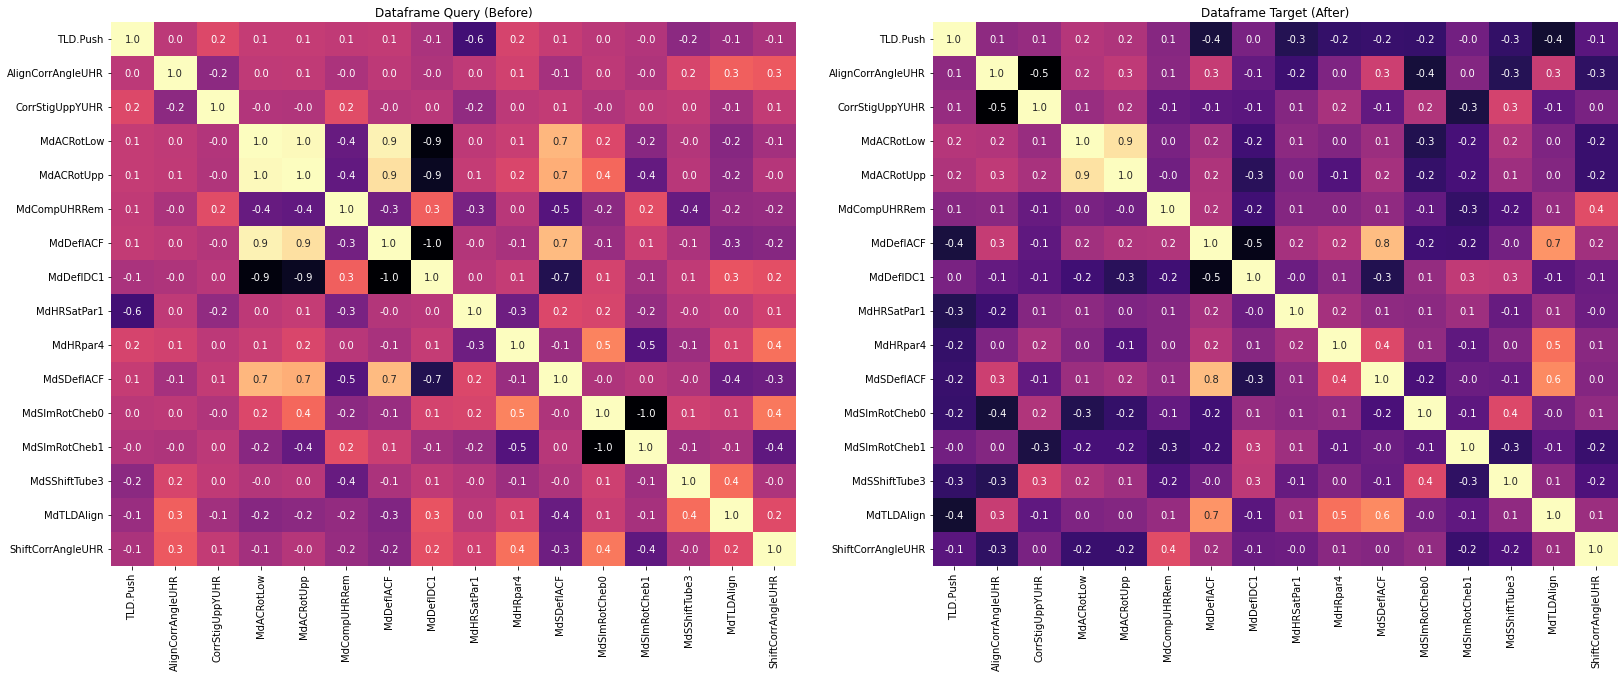

In [17]:
# Display correlations between features, before and after alignment

f, axes = plt.subplots(1, 2, figsize=(27,10))

sns.heatmap(train_query_val.corr(), annot=True, fmt='.1f', cmap="magma", cbar=False, ax=axes[0])
axes[0].set_title('Dataframe Query (Before)')

sns.heatmap(train_target_val.corr(), annot=True, fmt='.1f', cmap="magma", cbar=False,  ax=axes[1])
axes[1].set_title('Dataframe Target (After)')

plt.show()

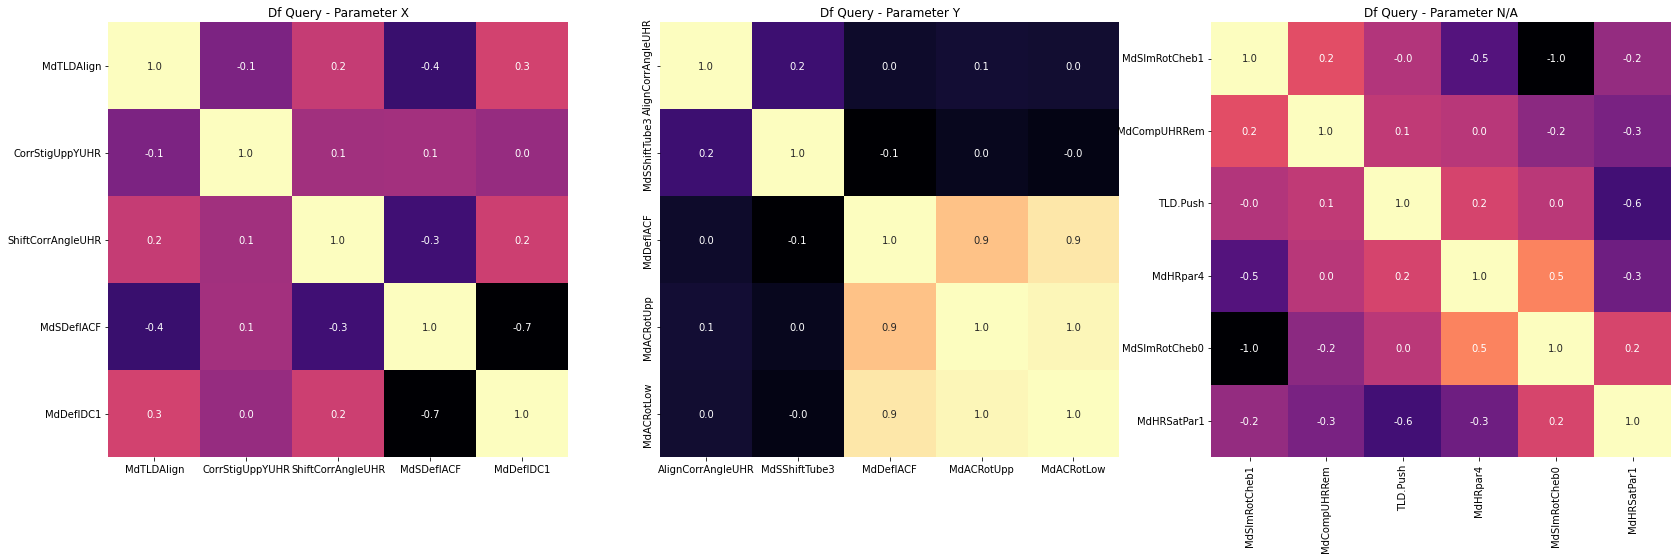

In [18]:
# Display correlations between features, based on common parameters, query data

df_train_query_x = train_query_val[['MdTLDAlign','CorrStigUppYUHR','ShiftCorrAngleUHR','MdSDeflACF','MdDeflDC1']]
df_train_query_y = train_query_val[['AlignCorrAngleUHR','MdSShiftTube3','MdDeflACF','MdACRotUpp','MdACRotLow']]
df_train_query_n = train_query_val[['MdSImRotCheb1','MdCompUHRRem','TLD.Push','MdHRpar4','MdSImRotCheb0','MdHRSatPar1']]

f, axes = plt.subplots(1, 3, figsize=(28,8))

sns.heatmap(df_train_query_x.corr(), annot=True, fmt='.1f', cmap="magma", cbar=False, ax=axes[0])
axes[0].set_title('Df Query - Parameter X')

sns.heatmap(df_train_query_y.corr(), annot=True, fmt='.1f', cmap="magma", cbar=False,  ax=axes[1])
axes[1].set_title('Df Query - Parameter Y')

sns.heatmap(df_train_query_n.corr(), annot=True, fmt='.1f', cmap="magma", cbar=False,  ax=axes[2])
axes[2].set_title('Df Query - Parameter N/A')

plt.show()

In Query data, most correlation can be observed in Y parameters

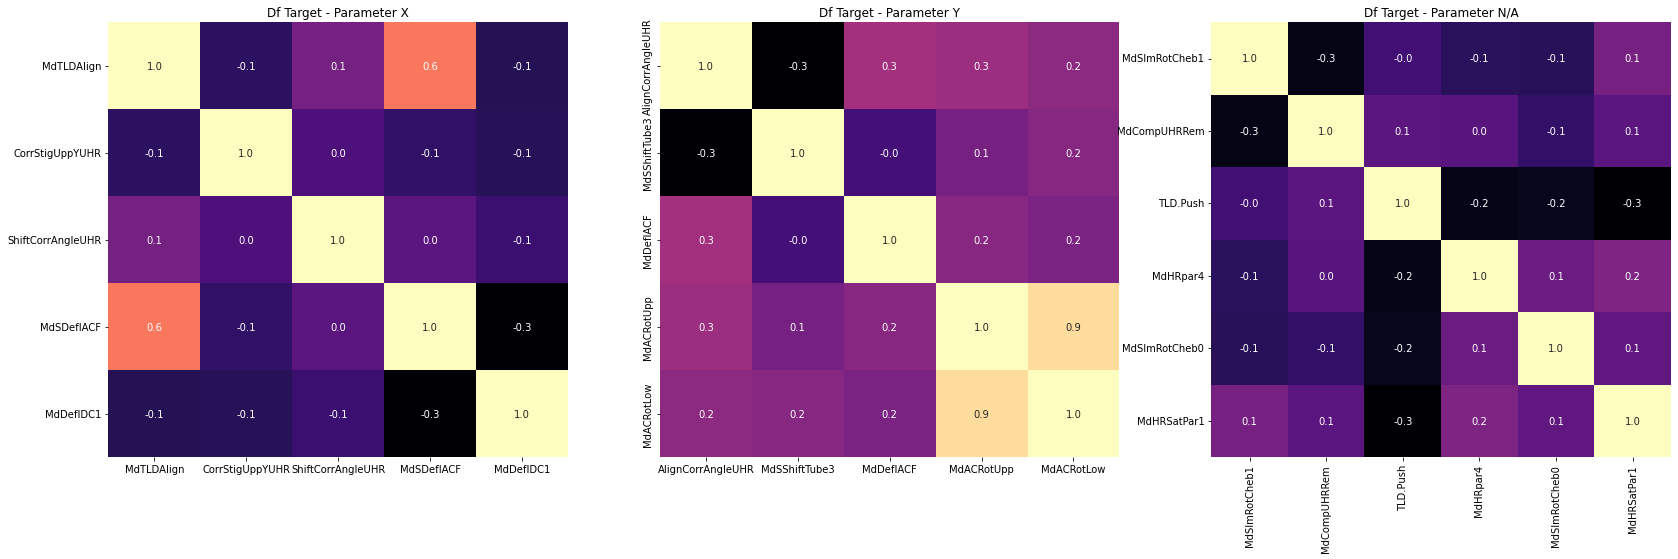

In [19]:
# Display correlations between features, based on common parameters, target data

df_train_target_x = train_target_val[['MdTLDAlign','CorrStigUppYUHR','ShiftCorrAngleUHR','MdSDeflACF','MdDeflDC1']]
df_train_target_y = train_target_val[['AlignCorrAngleUHR','MdSShiftTube3','MdDeflACF','MdACRotUpp','MdACRotLow']]
df_train_target_n = train_target_val[['MdSImRotCheb1','MdCompUHRRem','TLD.Push','MdHRpar4','MdSImRotCheb0','MdHRSatPar1']]

f, axes = plt.subplots(1, 3, figsize=(28,8))

sns.heatmap(df_train_target_x.corr(), annot=True, fmt='.1f', cmap="magma", cbar=False, ax=axes[0])
axes[0].set_title('Df Target - Parameter X')

sns.heatmap(df_train_target_y.corr(), annot=True, fmt='.1f', cmap="magma", cbar=False,  ax=axes[1])
axes[1].set_title('Df Target - Parameter Y')

sns.heatmap(df_train_target_n.corr(), annot=True, fmt='.1f', cmap="magma", cbar=False,  ax=axes[2])
axes[2].set_title('Df Target - Parameter N/A')

plt.show()

Most of the correlation is gone after alignment.

In [20]:
# Display skew of train query features 
skew_features_q = train_query_val.apply(lambda x: skew(x)).sort_values(ascending=False)
df_skew_q = pd.DataFrame({'Feature':skew_features_q.index, 'Skew':skew_features_q.values})

skew_features_t = train_target_val.apply(lambda x: skew(x)).sort_values(ascending=False)
df_skew_t = pd.DataFrame({'Feature':skew_features_t.index, 'Skew':skew_features_t.values})

trace1 = go.Bar(x=df_skew_q['Feature'], y=df_skew_q['Skew'], name='Train Query Skew')
trace2 = go.Bar(x=df_skew_t['Feature'], y=df_skew_t['Skew'], name='Train Target Skew')

fig = make_subplots(rows=1, cols=2)

fig.add_trace(trace1, row=1, col=1)
fig.add_trace(trace2, row=1, col=2)

fig.update_layout(title='Skew of Train features',width=1000, height=450)

fig.show()

Train dataset is heavily skewed, normalization techniques will  be required for model training. Data skew improves after alignment.

In [21]:
# Display Paired T-Test results for train dataset

t_statistic, p_value = stats.ttest_rel(train_query_val, train_target_val)

result_tt_df = pd.DataFrame(t_statistic.reshape(1, -1), columns=train_target_val.columns)

fig = go.Figure()
for col in result_tt_df.columns:
    rounded_val = round(result_tt_df[col][0], 1)
    fig.add_trace(go.Bar(x=[col], y=[result_tt_df[col][0]], name=col, text=rounded_val, textposition='auto',textangle=0 ))

fig.update_layout(title='Paired t-test results - train dataset', barmode='group',width=800, height=500)
fig.show()

In [22]:
# Display Paired T-Test results for train dataset

result_p_df = pd.DataFrame(p_value.reshape(1, -1), columns=train_target_val.columns)

fig = go.Figure()
for col in result_p_df.columns:
    rounded_val = round(result_tt_df[col][0], 1)
    fig.add_trace(go.Bar(x=[col], y=[result_p_df[col][0]], name=col, text=rounded_val, textposition='auto',textangle=0 ))

fig.update_layout(title='P-values - train dataset', barmode='group',width=800, height=500)
fig.show()

Functions for ML section

In [23]:
# Function for tabular scoring of ML model performance

def score_table_eval(y_pred,feature):

  df_eval = pd.DataFrame()
  df_eval['Test_Query'] = X_val[feature]
  df_eval['ID_ref'] = df_eval.index.astype(str)
  df_eval['Test_Target'] = y_val
  df_eval['Pred_Start'] = y_pred
  df_eval['MeasAlgnWrk'] = abs(df_eval['Test_Query'] - df_eval['Test_Target'])
  df_eval['PredAlgnWrk'] = abs(df_eval['Pred_Start'] - df_eval['Test_Target'])
  df_eval['%improved'] = round(((df_eval['MeasAlgnWrk']-df_eval['PredAlgnWrk'])/(df_eval['MeasAlgnWrk']))*100,2)
  df_eval['ML_success'] = df_eval['MeasAlgnWrk'] > df_eval['PredAlgnWrk'] 

  df_eval.loc[8,'Custom_Metrics'] = "Total Manual Alignment w/o ML (measured) :"
  df_eval.loc[8,'Metrics_Val'] = round(df_eval['MeasAlgnWrk'].sum(),5)
  df_eval.loc[10,'Custom_Metrics'] = "Total Manual Alignment with ML (predicted) :"
  df_eval.loc[10,'Metrics_Val'] = round(df_eval['PredAlgnWrk'].sum(),5)
  df_eval.loc[12,'Custom_Metrics'] = "Total Manual Alignment Difference :"
  df_eval.loc[12,'Metrics_Val'] = round(df_eval['MeasAlgnWrk'].sum() - df_eval['PredAlgnWrk'].sum(),5)
  df_eval.loc[13,'Custom_Metrics'] = "Total Improvement Ratio [%]:"
  df_eval.loc[13,'Metrics_Val'] = round((df_eval['MeasAlgnWrk'].sum() - df_eval['PredAlgnWrk'].sum())/(df_eval['MeasAlgnWrk'].sum())*100,2)
  df_eval.loc[16,'Custom_Metrics'] = "Avg Improvement per piece [%]:"
  df_eval.loc[16,'Metrics_Val'] = df_eval['%improved'].median()

  df_eval = df_eval.fillna('')

  return df_eval

In [24]:
# Function for visual scoring of ML model performance

def score_graph_eval(df):
  out_box1 = widgets.Output()
  out_box2 = widgets.Output()

  with out_box1:
    markers = ["x", "star", "x"]
    colors = ["red", "green", "blue"]
    fig = go.Figure()

    for i, col in enumerate(['Test_Query', 'Test_Target', 'Pred_Start']):
        fig.add_trace(
            go.Scatter(
                x=df['ID_ref'],
                y=df[col],
                name=col,
                mode='markers+lines',
                marker=dict(symbol=markers[i], size=10, color=colors[i]),
                line=dict(dash='dot' if i == 0 else 'solid')
            )
        )

    fig.update_layout(
        width=800,
        height=450,
        title='Alignment Starting Position Improvement Prediction',
        xaxis_title='ID_ref',
        yaxis_title='Alignment Actual Value',
        legend=dict(title='')
    )
    
    fig.show(renderer='colab')

  with out_box2:
    fig = px.bar(df, x="ID_ref", y=["MeasAlgnWrk", "PredAlgnWrk"], barmode="overlay",
                title="Alignment Work Reduction Prediction", color_discrete_sequence=["red", "green"], opacity=1)

    for i in range(0, len(fig.data), 2):
      fig.data[i].text = df['%improved'].apply(lambda x: str(round(x, 2)) + '%')
      fig.data[i].textposition = 'outside'

    fig.update_layout(width=800, height=450, title={'x': 0.5},yaxis_title="Alignment Actual Value")
    fig.show(renderer="colab")

  grid = GridspecLayout(1, 3)
  grid[:, 0:1] = out_box1
  grid[:, 1:2] = out_box2
  display(grid)

In [25]:
# Function for getting predictions

def getrmse(Xax,X_valx,model):

  scaler_mm = MinMaxScaler()
  X_scaled = scaler_mm.fit_transform(Xax)
  X_scaled_val = scaler_mm.fit_transform(X_valx)

  model.fit(X_scaled, y_1d)
  y_pred = model.predict(X_scaled_val)

  return y_pred

In [26]:
# Function for feature selection decision making

def get_fe_eval(Xax,X_valx,y_pred,model,feature):

  fe_df = pd.DataFrame(columns=['dropped', 'score_AIpp', 'score_diff'])

  y_pred = getrmse(Xax, X_valx,model)
  df_eval = score_table_eval(y_pred,feature)
  score_AIpp = df_eval.iloc[4, 9]
  fe_df = fe_df.append({'dropped': "none", 'score_AIpp': score_AIpp, 'score_diff': 0}, ignore_index=True)

  for col in Xax.columns:
      Xax_copy = Xax.drop(col, axis=1)
      X_valx_copy = X_valx.drop(col, axis=1)
      dropped = col
      y_pred = getrmse(Xax_copy, X_valx_copy,model)
      df_eval = score_table_eval(y_pred,feature)
      score_AIpp = df_eval.iloc[4, 9]
      score_diff = score_AIpp - fe_df.iloc[0, 1] 
      fe_df = fe_df.append({'dropped': dropped, 'score_AIpp': score_AIpp, 'score_diff': score_diff}, ignore_index=True)
      Xax_copy[col] = Xax[col]
      X_valx_copy[col] = X_valx[col]

  fe_df['Feature_Selection'] = fe_df['score_diff'].apply(lambda x: 'Keep' if x < 0 else 'Drop')

  return fe_df

In [27]:
def xgb_fe_graph(model,Xax):

  importance = model.get_booster().get_score(importance_type="weight")

  feature_names = Xax.columns
  feature_importance = pd.DataFrame.from_dict(data=importance, orient='index', columns=["score"])
  feature_importance.index = feature_importance.index.map(lambda x: feature_names[int(x[1:])])

  feature_importance = feature_importance.sort_values(by="score", ascending=False)

  fig = px.bar(feature_importance, x=feature_importance.index, y="score", color="score", color_continuous_scale='Bluered_r', title="Feature Importance XGBoost")
  fig.update_layout(width=400, height=450, title={'x':0.5})
  fig.show(renderer="colab")

In [28]:
# Function for visualization of feature importance for models

def get_graph_fe(modelxgb,modelsvr):

  importance_xgb = model_xgboost.get_booster().get_score(importance_type="weight")
  feature_names = Xax_xgb.columns
  feature_importance_xgb = pd.DataFrame.from_dict(data=importance_xgb, orient='index', columns=["score"])
  feature_importance_xgb.index = feature_importance_xgb.index.map(lambda x: feature_names[int(x[1:])])
  feature_importance_xgb = feature_importance_xgb.sort_values(by="score", ascending=False)

  trace1 = go.Bar(x=feature_importance_xgb.index, y=feature_importance_xgb['score'], marker=dict(color=feature_importance_xgb['score'], colorscale='Bluered_r'), name="XGBoost")

  result = permutation_importance(model_svr, X_scaled_val_svr, y_1d_val, n_repeats=10, random_state=42)
  importances_svr = pd.Series(result.importances_mean, index=Xax_svr.columns)
  feature_importance_svr = pd.DataFrame({'score': importances_svr})
  feature_importance_svr = feature_importance_svr.sort_values(by="score", ascending=False)

  trace2 = go.Bar(x=feature_importance_svr.index, y=feature_importance_svr['score'], marker=dict(color=feature_importance_svr['score'], colorscale='Bluered_r'), name="SVR")

  fig = sp.make_subplots(rows=1, cols=2)
  fig.add_trace(trace1, row=1, col=1)
  fig.add_trace(trace2, row=1, col=2)

  fig.update_xaxes(title_text="XGBoost", row=1, col=1, title_font=dict(size=14))
  fig.update_xaxes(title_text="SVR", row=1, col=2, title_font=dict(size=14))

  fig.update_layout(width=1000, height=450, title={'text': "Feature Importance Overview", 'x': 0.5},showlegend=False)
  fig.show(renderer="colab")

In [29]:
# Set up cross-validation and CV scoring function

kfolds = KFold(n_splits=3, shuffle=True, random_state=42)

def cv_rmse(model,Xax):
    rmse = np.sqrt(-cross_val_score(model, Xax, y_1d, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

 Section 3 - Machine Learning Models

3.1 Alignment parameter **MdTLDAlign**

In [30]:
# Load data, perform Feature Selection

Xa = train_query_val

Xax_svr = Xa.drop(['TLD.Push','MdSDeflACF','MdDeflACF','MdSImRotCheb0'], axis=1)
Xax_xgb = Xa.drop(['MdSImRotCheb1','MdSImRotCheb0','MdSDeflACF','MdDeflDC1','MdDeflACF','MdACRotUpp','TLD.Push','MdHRSatPar1','AlignCorrAngleUHR','MdHRpar4','MdSShiftTube3','MdACRotLow'], axis=1)

y = train_target_val['MdTLDAlign']
y_1d = y.values.reshape(-1, 1)

X_val = test_query_val
X_valx_svr = X_val.drop(['TLD.Push','MdSDeflACF','MdDeflACF','MdSImRotCheb0'], axis=1)
X_valx_xgb = X_val.drop(['MdSImRotCheb1','MdSImRotCheb0','MdSDeflACF','MdDeflDC1','MdDeflACF','MdACRotUpp','TLD.Push','MdHRSatPar1','AlignCorrAngleUHR','MdHRpar4','MdSShiftTube3','MdACRotLow'], axis=1)

y_val = test_target_val['MdTLDAlign']
y_1d_val = y_val.values.reshape(-1, 1)

In [31]:
# Model tuning - XGBoost
model_xgboost = XGBRegressor(max_depth =3,
                       n_estimators = 600,
                       learning_rate = 0.1,
                       reg_alpha = 0.0001)

model_svr = SVR(C= 20,
          epsilon= 0.003,
          gamma=0.0003
          )

# Cross Validation on Train set
xgb_train = make_pipeline(MinMaxScaler(), model_xgboost)
score_cv_xgb = cv_rmse(xgb_train,Xax_xgb).mean()

# Cross Validation on Train set
svr_train = make_pipeline(MinMaxScaler(), model_svr)
score_cv_svr = cv_rmse(svr_train,Xax_svr).mean()

# Actual Prediciton on Test set
scaler_mm = MinMaxScaler()
X_scaled_xgb = scaler_mm.fit_transform(Xax_xgb)
X_scaled_val_xgb = scaler_mm.fit_transform(X_valx_xgb)
X_scaled_svr = scaler_mm.fit_transform(Xax_svr)
X_scaled_val_svr = scaler_mm.fit_transform(X_valx_svr)

model_xgboost.fit(X_scaled_xgb, y_1d)
y_pred_xgb = model_xgboost.predict(X_scaled_val_xgb)
mse_xgb = mean_squared_error(y_1d_val, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)

model_svr.fit(X_scaled_svr, y_1d)
y_pred_svr = model_svr.predict(X_scaled_val_svr)
mse_svr = mean_squared_error(y_1d_val, y_pred_svr)
rmse_svr = np.sqrt(mse_svr)

# Check for Overfitting
print(f"XGBoost Train RMSE: {round(score_cv_xgb,7)}")
print(f"XGBoost Test RMSE: {round(rmse_xgb,7)}")

print(f"SVR Train RMSE: {round(score_cv_svr,7)}")
print(f"SVR Test RMSE: {round(rmse_svr,7)}")

XGBoost Train RMSE: 0.0361665
XGBoost Test RMSE: 0.0058977
SVR Train RMSE: 0.0327806
SVR Test RMSE: 0.0047895


Both models perform better on Test data than on Train data, showing no overfitting

In [32]:
xgbscore_MdTLDAlign = score_table_eval(y_pred_xgb,"MdTLDAlign")
xgbscore_MdTLDAlign

,Test_Query,ID_ref,Test_Target,Pred_Start,MeasAlgnWrk,PredAlgnWrk,%improved,ML_success,Custom_Metrics,Metrics_Val
ID,,,,,,,,,,
8,-0.065936,8,-0.065602,-0.062777,0.000334,0.002825,-745.38,False,Total Manual Alignment w/o ML (measured) :,0.30898
10,-0.129167,10,-0.069280,-0.061492,0.059887,0.007788,87.00,True,Total Manual Alignment with ML (predicted) :,0.05841
12,-0.069792,12,-0.066686,-0.066178,0.003105,0.000508,83.64,True,Total Manual Alignment Difference :,0.25057
13,0.000000,13,-0.067342,-0.072414,0.067342,0.005072,92.47,True,Total Improvement Ratio [%]:,81.1
16,-0.081250,16,-0.071445,-0.072345,0.009805,0.000901,90.81,True,Avg Improvement per piece [%]:,80.79
17,-0.066964,17,-0.069635,-0.071445,0.002671,0.001811,32.20,True,,
19,-0.067405,19,-0.055345,-0.066901,0.012060,0.011555,4.19,True,,
22,0.000000,22,-0.063194,-0.069319,0.063194,0.006125,90.31,True,,
25,-0.018750,25,-0.060548,-0.069767,0.041798,0.009219,77.94,True,,


In [33]:
svrscore_MdTLDAlign = score_table_eval(y_pred_svr,"MdTLDAlign")
svrscore_MdTLDAlign

,Test_Query,ID_ref,Test_Target,Pred_Start,MeasAlgnWrk,PredAlgnWrk,%improved,ML_success,Custom_Metrics,Metrics_Val
ID,,,,,,,,,,
8,-0.065936,8,-0.065602,-0.064399,0.000334,0.001203,-259.85,False,Total Manual Alignment w/o ML (measured) :,0.30898
10,-0.129167,10,-0.069280,-0.064967,0.059887,0.004312,92.80,True,Total Manual Alignment with ML (predicted) :,0.04429
12,-0.069792,12,-0.066686,-0.057810,0.003105,0.008876,-185.85,False,Total Manual Alignment Difference :,0.26469
13,0.000000,13,-0.067342,-0.065636,0.067342,0.001706,97.47,True,Total Improvement Ratio [%]:,85.66
16,-0.081250,16,-0.071445,-0.069839,0.009805,0.001605,83.63,True,Avg Improvement per piece [%]:,86.555
17,-0.066964,17,-0.069635,-0.066904,0.002671,0.002730,-2.24,False,,
19,-0.067405,19,-0.055345,-0.064181,0.012060,0.008836,26.73,True,,
22,0.000000,22,-0.063194,-0.061278,0.063194,0.001916,96.97,True,,
25,-0.018750,25,-0.060548,-0.059884,0.041798,0.000664,98.41,True,,


In [34]:
svr_fe = get_fe_eval(Xax_svr,X_valx_svr,y_pred_svr,model_svr,"MdTLDAlign")
svr_fe

,dropped,score_AIpp,score_diff,Feature_Selection
0,none,86.555,0,Drop
1,AlignCorrAngleUHR,73.565,-12.99,Keep
2,CorrStigUppYUHR,82.295,-4.26,Keep
3,MdACRotLow,76.310,-10.245,Keep
4,MdACRotUpp,80.615,-5.94,Keep
5,MdCompUHRRem,67.490,-19.065,Keep
6,MdDeflDC1,78.640,-7.915,Keep
7,MdHRSatPar1,52.535,-34.02,Keep
8,MdHRpar4,78.940,-7.615,Keep
9,MdSImRotCheb1,74.270,-12.285,Keep


In [35]:
xgb_fe = get_fe_eval(Xax_xgb,X_valx_xgb,y_pred_xgb,model_xgboost,"MdTLDAlign")
xgb_fe

,dropped,score_AIpp,score_diff,Feature_Selection
0,none,80.790,0,Drop
1,CorrStigUppYUHR,74.275,-6.515,Keep
2,MdCompUHRRem,80.250,-0.54,Keep
3,MdTLDAlign,-8.520,-89.31,Keep
4,ShiftCorrAngleUHR,29.105,-51.685,Keep


In [36]:
score_graph_eval(svrscore_MdTLDAlign)

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

In [37]:
score_graph_eval(xgbscore_MdTLDAlign)

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

In [38]:
xgb_fe_graph(model_xgboost,Xax_xgb)

3.2 Alignment parameter **AlignCorrAngleUHR**

In [39]:
# Reload data for models

Xa = train_query_val
Xax_xgb = Xa.drop(['TLD.Push','MdSDeflACF','MdDeflACF','MdACRotLow','MdSShiftTube3'], axis=1)

y = train_target_val['AlignCorrAngleUHR']
y_1d = y.values.reshape(-1, 1)

X_val = test_query_val
X_valx_xgb = X_val.drop(['TLD.Push','MdSDeflACF','MdDeflACF','MdACRotLow','MdSShiftTube3'], axis=1)

y_val = test_target_val['AlignCorrAngleUHR']
y_1d_val = y_val.values.reshape(-1, 1)

In [40]:
# ML Model tuning

model_xgboost = RandomForestRegressor(n_estimators = 600,
                                      max_depth = 6,
                                      min_samples_split = 3,
                                      min_samples_leaf = 2,
                                      random_state = 42
                                      )
  
# Cross Validation on Train set
xgb_train = make_pipeline(MinMaxScaler(), model_xgboost)
score_cv_xgb = cv_rmse(xgb_train,Xax_xgb).mean()

# Actual Prediciton on Test set
scaler_s = MinMaxScaler()
X_scaled_xgb = scaler_s.fit_transform(Xax_xgb)
X_scaled_val_xgb = scaler_s.fit_transform(X_valx_xgb)

# model_xgboost.fit(X_scaled_xgb, y_1d)
model_xgboost.fit(Xax_xgb, y_1d)
y_pred_xgb = model_xgboost.predict(X_scaled_val_xgb)
mse_xgb = mean_squared_error(y_1d_val, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)

# Check for Overfitting

print(f"RandomForest Train RMSE: {round(score_cv_xgb,7)}")
print(f"RandomForest Test RMSE: {round(rmse_xgb,7)}")

RandomForest Train RMSE: 0.0001659
RandomForest Test RMSE: 0.0001303


In [41]:
rfscore_AlignCorrAngleUHR = score_table_eval(y_pred_xgb,"AlignCorrAngleUHR")
rfscore_AlignCorrAngleUHR 

,Test_Query,ID_ref,Test_Target,Pred_Start,MeasAlgnWrk,PredAlgnWrk,%improved,ML_success,Custom_Metrics,Metrics_Val
ID,,,,,,,,,,
8,-0.000082,8,-0.000034,-0.000112,0.000048,0.000078,-62.57,False,Total Manual Alignment w/o ML (measured) :,0.00134
10,0.000000,10,-0.000088,-0.000118,0.000088,0.000030,65.37,True,Total Manual Alignment with ML (predicted) :,0.00097
12,0.000082,12,-0.000039,-0.000098,0.000121,0.000058,51.83,True,Total Manual Alignment Difference :,0.00037
13,0.000006,13,-0.000201,-0.000112,0.000207,0.000088,57.30,True,Total Improvement Ratio [%]:,27.5
16,-0.000183,16,-0.000160,-0.000118,0.000023,0.000042,-85.43,False,Avg Improvement per piece [%]:,45.82
17,-0.000277,17,-0.000180,-0.000121,0.000098,0.000059,39.81,True,,
19,0.000000,19,-0.000108,-0.000112,0.000108,0.000004,96.33,True,,
22,-0.000023,22,-0.000102,-0.000097,0.000079,0.000004,94.51,True,,
25,-0.000127,25,0.000292,-0.000112,0.000419,0.000404,3.57,True,,


In [42]:
rf_fe = get_fe_eval(Xax_xgb,X_valx_xgb,y_pred_xgb,model_xgboost,"AlignCorrAngleUHR")
rf_fe

,dropped,score_AIpp,score_diff,Feature_Selection
0,none,17.535,0,Drop
1,AlignCorrAngleUHR,10.615,-6.92,Keep
2,CorrStigUppYUHR,15.795,-1.74,Keep
3,MdACRotUpp,16.380,-1.155,Keep
4,MdCompUHRRem,15.740,-1.795,Keep
5,MdDeflDC1,16.975,-0.56,Keep
6,MdHRSatPar1,12.325,-5.21,Keep
7,MdHRpar4,19.150,1.615,Drop
8,MdSImRotCheb0,16.595,-0.94,Keep
9,MdSImRotCheb1,16.685,-0.85,Keep


In [43]:
score_graph_eval(rfscore_AlignCorrAngleUHR)

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

3.3 Alignment parameter **CorrStigUppYUHR**

In [44]:
# Reload data 

Xa = train_query_val
Xax_svr = Xa.drop(['MdHRSatPar1','AlignCorrAngleUHR','MdSImRotCheb1','MdDeflACF','MdACRotUpp','MdACRotLow','MdTLDAlign','MdCompUHRRem','MdDeflDC1'], axis=1)

y = train_target_val['CorrStigUppYUHR']
y_1d = y.values.reshape(-1, 1)

X_val = test_query_val
X_valx_svr = X_val.drop(['MdHRSatPar1','AlignCorrAngleUHR','MdSImRotCheb1','MdDeflACF','MdACRotUpp','MdACRotLow','MdTLDAlign','MdCompUHRRem','MdDeflDC1'], axis=1)

y_val = test_target_val['CorrStigUppYUHR']
y_1d_val = y_val.values.reshape(-1, 1)

In [45]:
# ML Model Training

model_svr = SVR(C= 25,
          epsilon= 0.0004,
          gamma=0.0004
          )

# Cross Validation on Train set
svr_train = make_pipeline(MinMaxScaler(), model_svr)
score_cv_svr = cv_rmse(svr_train,Xax_svr).mean()

# Actual Prediciton on Test set
scaler_mm = MinMaxScaler()
X_scaled_svr = scaler_mm.fit_transform(Xax_svr)
X_scaled_val_svr = scaler_mm.fit_transform(X_valx_svr)

model_svr.fit(X_scaled_svr, y_1d)
y_pred_svr = model_svr.predict(X_scaled_val_svr)
mse_svr = mean_squared_error(y_1d_val, y_pred_svr)
rmse_svr = np.sqrt(mse_svr)

# Check for Overfitting
print(f"SVR Train RMSE: {round(score_cv_svr,7)}")
print(f"SVR Test RMSE: {round(rmse_svr,7)}")

SVR Train RMSE: 0.0205297
SVR Test RMSE: 0.0141287


Error Test < Train : OK overfitting

In [46]:
svrscore_CorrStigUppYUHR = score_table_eval(y_pred_svr,"CorrStigUppYUHR")
svrscore_CorrStigUppYUHR

,Test_Query,ID_ref,Test_Target,Pred_Start,MeasAlgnWrk,PredAlgnWrk,%improved,ML_success,Custom_Metrics,Metrics_Val
ID,,,,,,,,,,
8,-0.002219,8,0.001885,-0.000542,0.004104,0.002427,40.86,True,Total Manual Alignment w/o ML (measured) :,0.13529
10,0.000000,10,0.015071,-0.011659,0.015071,0.026730,-77.36,False,Total Manual Alignment with ML (predicted) :,0.12892
12,-0.024475,12,-0.010388,-0.017552,0.014086,0.007164,49.14,True,Total Manual Alignment Difference :,0.00637
13,-0.008784,13,0.006913,-0.005645,0.015697,0.012558,20.00,True,Total Improvement Ratio [%]:,4.71
16,0.025680,16,0.008452,0.008365,0.017228,0.000087,99.49,True,Avg Improvement per piece [%]:,29.24
17,0.010473,17,-0.002242,0.007686,0.012715,0.009928,21.92,True,,
19,0.000000,19,0.012620,0.004614,0.012620,0.008006,36.56,True,,
22,-0.019562,22,-0.030155,-0.004038,0.010593,0.026117,-146.55,False,,
25,0.001726,25,0.015339,0.007232,0.013613,0.008107,40.45,True,,


In [47]:
svr_fe = get_fe_eval(Xax_svr,X_valx_svr,y_pred_svr,model_svr,"CorrStigUppYUHR")
svr_fe

,dropped,score_AIpp,score_diff,Feature_Selection
0,none,29.240,0,Drop
1,TLD.Push,-11.925,-41.165,Keep
2,CorrStigUppYUHR,9.445,-19.795,Keep
3,MdHRpar4,2.650,-26.59,Keep
4,MdSDeflACF,28.280,-0.96,Keep
5,MdSImRotCheb0,-18.980,-48.22,Keep
6,MdSShiftTube3,13.720,-15.52,Keep
7,ShiftCorrAngleUHR,21.740,-7.5,Keep


In [48]:
score_graph_eval(svrscore_CorrStigUppYUHR)

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

3.4 Alignment parameter MdSShiftTube3

In [49]:
# Reload data 

Xa = train_query_val
Xax_xgb = Xa.drop(['MdDeflACF','CorrStigUppYUHR','ShiftCorrAngleUHR'], axis=1)

y = train_target_val['MdSShiftTube3']
y_1d = y.values.reshape(-1, 1)

X_val = test_query_val
X_valx_xgb = X_val.drop(['MdDeflACF','CorrStigUppYUHR','ShiftCorrAngleUHR'], axis=1)

y_val = test_target_val['MdSShiftTube3']
y_1d_val = y_val.values.reshape(-1, 1)

In [50]:
# ML Model Training
model_xgboost = XGBRegressor(max_depth =7,
                       n_estimators = 600,
                       learning_rate = 0.005,
                       reg_alpha = 0.00001,
                       objective='reg:squarederror'
                       )

# Cross Validation on Train set
xgb_train = make_pipeline(MinMaxScaler(), model_xgboost)
score_cv_xgb = cv_rmse(xgb_train,Xax_xgb).mean()

# Actual Prediciton on Test set
scaler_mm = MinMaxScaler()
X_scaled_xgb = scaler_mm.fit_transform(Xax_xgb)
X_scaled_val_xgb = scaler_mm.fit_transform(X_valx_xgb)

model_xgboost.fit(X_scaled_xgb, y_1d)
y_pred_xgb = model_xgboost.predict(X_scaled_val_xgb)
mse_xgb = mean_squared_error(y_1d_val, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)

# Check for Overfitting
print(f"XGBoost Train RMSE: {round(score_cv_xgb,7)}")
print(f"XGBoost Test RMSE: {round(rmse_xgb,7)}")

XGBoost Train RMSE: 48.5926582
XGBoost Test RMSE: 31.7789441


Test Error < Train Error : OK Overfitting

In [51]:
xgbscore_MdSShiftTube3 = score_table_eval(y_pred_xgb,'MdSShiftTube3')
xgbscore_MdSShiftTube3

,Test_Query,ID_ref,Test_Target,Pred_Start,MeasAlgnWrk,PredAlgnWrk,%improved,ML_success,Custom_Metrics,Metrics_Val
ID,,,,,,,,,,
8,10.661954,8,-12.157322,-21.069418,22.819276,8.912096,60.94,True,Total Manual Alignment w/o ML (measured) :,498.70344
10,-29.817424,10,-100.327584,-36.579876,70.510160,63.747708,9.59,True,Total Manual Alignment with ML (predicted) :,337.46911
12,-114.771656,12,-35.373122,-11.346097,79.398534,24.027025,69.74,True,Total Manual Alignment Difference :,161.23433
13,18.273001,13,-52.650534,-18.884842,70.923535,33.765692,52.39,True,Total Improvement Ratio [%]:,32.33
16,47.688876,16,10.375920,28.148214,37.312956,17.772294,52.37,True,Avg Improvement per piece [%]:,39.255
17,-20.918074,17,-18.726773,-35.351894,2.191301,16.625121,-658.69,False,,
19,5.936010,19,29.190904,-20.629072,23.254894,49.819976,-114.23,False,,
22,70.349443,22,35.957977,56.637791,34.391466,20.679814,39.87,True,,
25,82.999339,25,8.791515,28.148214,74.207825,19.356700,73.92,True,,


In [52]:
xgb_fe = get_fe_eval(Xax_xgb,X_valx_xgb,y_pred_xgb,model_xgboost,'MdSShiftTube3')
xgb_fe

,dropped,score_AIpp,score_diff,Feature_Selection
0,none,39.255,0,Drop
1,TLD.Push,41.095,1.84,Drop
2,AlignCorrAngleUHR,38.185,-1.07,Keep
3,MdACRotLow,39.255,0.0,Drop
4,MdACRotUpp,39.255,0.0,Drop
5,MdCompUHRRem,37.635,-1.62,Keep
6,MdDeflDC1,39.255,0.0,Drop
7,MdHRSatPar1,34.450,-4.805,Keep
8,MdHRpar4,41.785,2.53,Drop
9,MdSDeflACF,39.255,0.0,Drop


In [53]:
score_graph_eval(xgbscore_MdSShiftTube3)

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

In [54]:
xgb_fe_graph(model_xgboost,Xax_xgb)

3.5 Alignment parameter **ShiftCorrAngleUHR**

In [55]:
# Reload data 

Xa = train_query_val
Xax_xgb = Xa.drop(['TLD.Push', 'AlignCorrAngleUHR', 'CorrStigUppYUHR', 'MdACRotLow','MdACRotUpp', 'MdCompUHRRem', 'MdDeflACF', 'MdDeflDC1', 'MdHRSatPar1','MdHRpar4', 'MdSDeflACF', 'MdSImRotCheb0', 'MdSImRotCheb1','MdSShiftTube3', 'MdTLDAlign'], axis=1)

y = train_target_val['ShiftCorrAngleUHR']
y_1d = y.values.reshape(-1, 1)

X_val = test_query_val
X_valx_xgb = X_val.drop(['TLD.Push', 'AlignCorrAngleUHR', 'CorrStigUppYUHR', 'MdACRotLow','MdACRotUpp', 'MdCompUHRRem', 'MdDeflACF', 'MdDeflDC1', 'MdHRSatPar1','MdHRpar4', 'MdSDeflACF', 'MdSImRotCheb0', 'MdSImRotCheb1','MdSShiftTube3', 'MdTLDAlign'], axis=1)

y_val = test_target_val['ShiftCorrAngleUHR']
y_1d_val = y_val.values.reshape(-1, 1)

In [56]:
# ML Model Training
model_xgboost = XGBRegressor(max_depth =7,
                       n_estimators = 200,
                       learning_rate = 0.04,
                       reg_alpha = 0.00006,
                       reg_lambda = 0.006,
                       objective='reg:squarederror'
                       )

# Cross Validation on Train set
xgb_train = make_pipeline(MinMaxScaler(), model_xgboost)
score_cv_xgb = cv_rmse(xgb_train,Xax_xgb).mean()

# Actual Prediciton on Test set
scaler_mm = MinMaxScaler()
X_scaled_xgb = scaler_mm.fit_transform(Xax_xgb)
X_scaled_val_xgb = scaler_mm.fit_transform(X_valx_xgb)

model_xgboost.fit(X_scaled_xgb, y_1d)
y_pred_xgb = model_xgboost.predict(X_scaled_val_xgb)
mse_xgb = mean_squared_error(y_1d_val, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)

# Check for Overfitting
print(f"XGBoost Train RMSE: {round(score_cv_xgb,7)}")
print(f"XGBoost Test RMSE: {round(rmse_xgb,7)}")

XGBoost Train RMSE: 0.0004629
XGBoost Test RMSE: 0.0003706


In [57]:
xgbscore_ShiftCorrAngleUHR = score_table_eval(y_pred_xgb,'ShiftCorrAngleUHR')
xgbscore_ShiftCorrAngleUHR

,Test_Query,ID_ref,Test_Target,Pred_Start,MeasAlgnWrk,PredAlgnWrk,%improved,ML_success,Custom_Metrics,Metrics_Val
ID,,,,,,,,,,
8,-0.000126,8,-0.000244,-0.000146,0.000118,0.000098,17.12,True,Total Manual Alignment w/o ML (measured) :,0.00369
10,0.000212,10,0.000345,0.000096,0.000132,0.000248,-88.05,False,Total Manual Alignment with ML (predicted) :,0.00314
12,0.000833,12,0.000028,0.000096,0.000805,0.000068,91.53,True,Total Manual Alignment Difference :,0.00055
13,0.000029,13,0.000123,0.000096,0.000094,0.000027,71.22,True,Total Improvement Ratio [%]:,14.84
16,-0.000208,16,-0.000324,-0.000146,0.000116,0.000179,-53.96,False,Avg Improvement per piece [%]:,-0.94
17,-0.000060,17,0.000000,0.000096,0.000060,0.000096,-59.08,False,,
19,0.000000,19,-0.000577,0.000096,0.000577,0.000673,-16.68,False,,
22,0.000775,22,0.000200,0.000096,0.000575,0.000104,81.90,True,,
25,0.000538,25,0.000321,0.000096,0.000217,0.000225,-3.62,False,,


In [58]:
score_graph_eval(xgbscore_ShiftCorrAngleUHR)

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

In [59]:
xgb_fe_graph(model_xgboost,Xax_xgb)

3.6 Alignment parameter **MdSImRotCheb1**

In [60]:
# Reload data 

Xa = train_query_val
Xax_xgb = Xa.drop(['CorrStigUppYUHR','ShiftCorrAngleUHR','MdSShiftTube3'], axis=1)

y = train_target_val['MdSImRotCheb1']
y_1d = y.values.reshape(-1, 1)

X_val = test_query_val
X_valx_xgb = X_val.drop(['CorrStigUppYUHR','ShiftCorrAngleUHR','MdSShiftTube3'], axis=1)

y_val = test_target_val['MdSImRotCheb1']
y_1d_val = y_val.values.reshape(-1, 1)

In [61]:
# Model tuning - XGBoost
model_xgboost = XGBRegressor(max_depth =8,
                       n_estimators = 500,
                       learning_rate = 0.04,
                       reg_alpha = 0.00006,
                       reg_lambda = 0.006,
                       subsample = 0.9,
                       objective='reg:squarederror'
                       )

# Cross Validation on Train set
xgb_train = make_pipeline(MinMaxScaler(), model_xgboost)
score_cv_xgb = cv_rmse(xgb_train,Xax_xgb).mean()

# Actual Prediciton on Test set
scaler_mm = MinMaxScaler()
X_scaled_xgb = scaler_mm.fit_transform(Xax_xgb)
X_scaled_val_xgb = scaler_mm.fit_transform(X_valx_xgb)

model_xgboost.fit(X_scaled_xgb, y_1d)
y_pred_xgb = model_xgboost.predict(X_scaled_val_xgb)
mse_xgb = mean_squared_error(y_1d_val, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)

# Check for Overfitting

print(f"XGBoost Train RMSE: {round(score_cv_xgb,7)}")
print(f"XGBoost Test RMSE: {round(rmse_xgb,7)}")

XGBoost Train RMSE: 0.005929
XGBoost Test RMSE: 0.0055956


Test Error < Train Error : OK Overfitting

In [62]:
xgbscore_MdSImRotCheb1 = score_table_eval(y_pred_xgb,'MdSImRotCheb1')
xgbscore_MdSImRotCheb1

,Test_Query,ID_ref,Test_Target,Pred_Start,MeasAlgnWrk,PredAlgnWrk,%improved,ML_success,Custom_Metrics,Metrics_Val
ID,,,,,,,,,,
8,0.3570,8,0.357000,0.361734,0.000000,0.004734,-inf,False,Total Manual Alignment w/o ML (measured) :,0.20309
10,0.2681,10,0.356543,0.359549,0.088443,0.003005,96.60,True,Total Manual Alignment with ML (predicted) :,0.05244
12,0.3570,12,0.363769,0.361340,0.006769,0.002428,64.12,True,Total Manual Alignment Difference :,0.15065
13,0.3570,13,0.362275,0.362955,0.005275,0.000680,87.10,True,Total Improvement Ratio [%]:,74.18
16,0.2681,16,0.340991,0.352673,0.072891,0.011682,83.97,True,Avg Improvement per piece [%]:,37.02
17,0.3570,17,0.363022,0.355944,0.006022,0.007077,-17.53,False,,
19,0.3570,19,0.352428,0.361791,0.004572,0.009362,-104.78,False,,
22,0.3570,22,0.368200,0.361184,0.011200,0.007017,37.35,True,,
25,0.3570,25,0.357190,0.358119,0.000190,0.000929,-390.17,False,,


In [63]:
xgb_fe = get_fe_eval(Xax_xgb,X_valx_xgb,y_pred_xgb,model_xgboost,'MdSImRotCheb1')
xgb_fe

,dropped,score_AIpp,score_diff,Feature_Selection
0,none,37.020,0,Drop
1,TLD.Push,36.665,-0.355,Keep
2,AlignCorrAngleUHR,-11.385,-48.405,Keep
3,MdACRotLow,37.020,0.0,Drop
4,MdACRotUpp,37.020,0.0,Drop
5,MdCompUHRRem,41.525,4.505,Drop
6,MdDeflACF,37.020,0.0,Drop
7,MdDeflDC1,37.020,0.0,Drop
8,MdHRSatPar1,32.650,-4.37,Keep
9,MdHRpar4,28.275,-8.745,Keep


In [64]:
score_graph_eval(xgbscore_MdSImRotCheb1)

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

In [65]:
xgb_fe_graph(model_xgboost,Xax_xgb)

3.7 Alignment parameter **MdSDeflACF**

In [66]:
# Reload data 

Xa = train_query_val
Xax_xgb = Xa.drop(['CorrStigUppYUHR','TLD.Push'], axis=1)

y = train_target_val['MdSDeflACF']
y_1d = y.values.reshape(-1, 1)

X_val = test_query_val
X_valx_xgb = X_val.drop(['CorrStigUppYUHR','TLD.Push'], axis=1)

y_val = test_target_val['MdSDeflACF']
y_1d_val = y_val.values.reshape(-1, 1)

In [67]:
# Model tuning - XGBoost
model_xgboost = XGBRegressor(max_depth =8,
                       n_estimators = 500,
                       learning_rate = 0.04,
                       reg_alpha = 0.00006,
                       reg_lambda = 0.006,
                       objective='reg:squarederror'
                       )

# Cross Validation on Train set
xgb_train = make_pipeline(MinMaxScaler(), model_xgboost)
score_cv_xgb = cv_rmse(xgb_train,Xax_xgb).mean()

# Actual Prediciton on Test set
scaler_mm = MinMaxScaler()
X_scaled_xgb = scaler_mm.fit_transform(Xax_xgb)
X_scaled_val_xgb = scaler_mm.fit_transform(X_valx_xgb)

model_xgboost.fit(X_scaled_xgb, y_1d)
y_pred_xgb = model_xgboost.predict(X_scaled_val_xgb)
mse_xgb = mean_squared_error(y_1d_val, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)

# Check for Overfitting

print(f"XGBoost Train RMSE: {round(score_cv_xgb,7)}")
print(f"XGBoost Test RMSE: {round(rmse_xgb,7)}")

XGBoost Train RMSE: 0.0040669
XGBoost Test RMSE: 0.0028867


Test Error < Train Error : OK Overfitting

In [68]:
xgbscore_MdSDeflACF = score_table_eval(y_pred_xgb,'MdSDeflACF')
xgbscore_MdSDeflACF

,Test_Query,ID_ref,Test_Target,Pred_Start,MeasAlgnWrk,PredAlgnWrk,%improved,ML_success,Custom_Metrics,Metrics_Val
ID,,,,,,,,,,
8,0.142600,8,0.128701,0.129179,0.013899,0.000478,96.56,True,Total Manual Alignment w/o ML (measured) :,0.16236
10,0.142600,10,0.127571,0.128883,0.015029,0.001311,91.28,True,Total Manual Alignment with ML (predicted) :,0.02091
12,0.142600,12,0.127703,0.129154,0.014897,0.001451,90.26,True,Total Manual Alignment Difference :,0.14145
13,0.142600,13,0.129814,0.129035,0.012786,0.000780,93.90,True,Total Improvement Ratio [%]:,87.12
16,0.142600,16,0.120727,0.129814,0.021873,0.009086,58.46,True,Avg Improvement per piece [%]:,92.12
17,0.131723,17,0.129774,0.128989,0.001949,0.000785,59.73,True,,
19,0.142600,19,0.128259,0.128458,0.014341,0.000200,98.61,True,,
22,0.142600,22,0.129665,0.128754,0.012935,0.000911,92.96,True,,
25,0.142600,25,0.130116,0.132095,0.012484,0.001979,84.15,True,,


In [69]:
xgb_fe = get_fe_eval(Xax_xgb,X_valx_xgb,y_pred_xgb,model_xgboost,'MdSDeflACF')
xgb_fe

,dropped,score_AIpp,score_diff,Feature_Selection
0,none,92.120,0,Drop
1,AlignCorrAngleUHR,87.760,-4.36,Keep
2,MdACRotLow,92.120,0.0,Drop
3,MdACRotUpp,92.120,0.0,Drop
4,MdCompUHRRem,92.120,0.0,Drop
5,MdDeflACF,92.120,0.0,Drop
6,MdDeflDC1,92.120,0.0,Drop
7,MdHRSatPar1,93.710,1.59,Drop
8,MdHRpar4,92.505,0.385,Drop
9,MdSDeflACF,92.120,0.0,Drop


In [70]:
score_graph_eval(xgbscore_MdSDeflACF)

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

In [71]:
xgb_fe_graph(model_xgboost,Xax_xgb)

3.8 Alignment parameter **MdDeflACF**

In [72]:
# Reload data 

Xa = train_query_val
Xax_xgb = Xa.drop(['TLD.Push','MdTLDAlign'], axis=1)

y = train_target_val['MdDeflACF']
y_1d = y.values.reshape(-1, 1)

X_val = test_query_val
X_valx_xgb = X_val.drop(['TLD.Push','MdTLDAlign'], axis=1)

y_val = test_target_val['MdDeflACF']
y_1d_val = y_val.values.reshape(-1, 1)

In [73]:
# ML Model Training

model_xgboost = RandomForestRegressor(n_estimators = 600,
                                      max_depth = 6,
                                      min_samples_split = 3,
                                      min_samples_leaf = 2,
                                      random_state = 42
                                      )
# Cross Validation on Train set
xgb_train = make_pipeline(MinMaxScaler(), model_xgboost)
score_cv_xgb = cv_rmse(xgb_train,Xax_xgb).mean()

# Actual Prediciton on Test set
scaler_mm = MinMaxScaler()
X_scaled_xgb = scaler_mm.fit_transform(Xax_xgb)
X_scaled_val_xgb = scaler_mm.fit_transform(X_valx_xgb)

model_xgboost.fit(X_scaled_xgb, y_1d)
y_pred_xgb = model_xgboost.predict(X_scaled_val_xgb)
mse_xgb = mean_squared_error(y_1d_val, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)

# Check for Overfitting
print(f"RandomForest Train RMSE: {round(score_cv_xgb,7)}")
print(f"RandomForest Test RMSE: {round(rmse_xgb,7)}")

RandomForest Train RMSE: 0.0022097
RandomForest Test RMSE: 0.0014033


Test Error < Train Error : OK Overfitting

In [74]:
rfscore_MdDeflACF = score_table_eval(y_pred_xgb,'MdDeflACF')
rfscore_MdDeflACF

,Test_Query,ID_ref,Test_Target,Pred_Start,MeasAlgnWrk,PredAlgnWrk,%improved,ML_success,Custom_Metrics,Metrics_Val
ID,,,,,,,,,,
8,0.145855,8,0.134250,0.135945,0.011605,0.001695,85.39,True,Total Manual Alignment w/o ML (measured) :,0.13664
10,0.145855,10,0.134864,0.134727,0.010991,0.000138,98.75,True,Total Manual Alignment with ML (predicted) :,0.01341
12,0.145855,12,0.134205,0.135014,0.011650,0.000809,93.06,True,Total Manual Alignment Difference :,0.12324
13,0.145855,13,0.134816,0.135212,0.011039,0.000396,96.41,True,Total Improvement Ratio [%]:,90.19
16,0.145855,16,0.134122,0.136269,0.011733,0.002147,81.70,True,Avg Improvement per piece [%]:,93.335
17,0.145855,17,0.135187,0.135840,0.010668,0.000653,93.88,True,,
19,0.145855,19,0.134284,0.134695,0.011571,0.000411,96.45,True,,
22,0.145855,22,0.135263,0.135279,0.010592,0.000016,99.85,True,,
25,0.145855,25,0.134125,0.136501,0.011730,0.002376,79.74,True,,


In [75]:
rf_fe = get_fe_eval(Xax_xgb,X_valx_xgb,y_pred_xgb,model_xgboost,'MdDeflACF')
rf_fe

,dropped,score_AIpp,score_diff,Feature_Selection
0,none,93.335,0,Drop
1,AlignCorrAngleUHR,89.620,-3.715,Keep
2,CorrStigUppYUHR,90.540,-2.795,Keep
3,MdACRotLow,93.440,0.105,Drop
4,MdACRotUpp,93.440,0.105,Drop
5,MdCompUHRRem,93.485,0.15,Drop
6,MdDeflACF,93.315,-0.02,Keep
7,MdDeflDC1,93.315,-0.02,Keep
8,MdHRSatPar1,93.245,-0.09,Keep
9,MdHRpar4,91.870,-1.465,Keep


In [76]:
score_graph_eval(rfscore_MdDeflACF)

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

3.9 Alignment parameter **MdACRotUpp**

In [77]:
# Reload data 

Xa = train_query_val
Xax_xgb = Xa.drop(['TLD.Push','MdSDeflACF','MdDeflACF','MdCompUHRRem','MdSImRotCheb0','MdACRotUpp'], axis=1)

y = train_target_val['MdACRotUpp']
y_1d = y.values.reshape(-1, 1)

X_val = test_query_val
X_valx_xgb = X_val.drop(['TLD.Push','MdSDeflACF','MdDeflACF','MdCompUHRRem','MdSImRotCheb0','MdACRotUpp'], axis=1)

y_val = test_target_val['MdACRotUpp']
y_1d_val = y_val.values.reshape(-1, 1)

In [78]:
# ML Model training

model_xgboost = XGBRegressor(max_depth =7,
                       n_estimators = 250,
                       learning_rate = 0.08,
                       reg_lambda = 0.1000006,
                       objective='reg:squarederror',
                       subsample = 0.7,
                       )

# Cross Validation on Train set
xgb_train = make_pipeline(MinMaxScaler(), model_xgboost)
score_cv_xgb = cv_rmse(xgb_train,Xax_xgb).mean()

# Actual Prediciton on Test set
scaler_mm = StandardScaler()
X_scaled_xgb = scaler_mm.fit_transform(Xax_xgb)
X_scaled_val_xgb = scaler_mm.fit_transform(X_valx_xgb)

model_xgboost.fit(X_scaled_xgb, y_1d)
y_pred_xgb = model_xgboost.predict(X_scaled_val_xgb)
mse_xgb = mean_squared_error(y_1d_val, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)

# Check for Overfitting
print(f"XGBoost Train RMSE: {round(score_cv_xgb,7)}")
print(f"XGBoost Test RMSE: {round(rmse_xgb,7)}")

XGBoost Train RMSE: 0.0070827
XGBoost Test RMSE: 0.0027344


Test Error < Train Error : OK Overfitting

In [79]:
xgbscore_MdACRotUpp = score_table_eval(y_pred_xgb,'MdACRotUpp')
xgbscore_MdACRotUpp

,Test_Query,ID_ref,Test_Target,Pred_Start,MeasAlgnWrk,PredAlgnWrk,%improved,ML_success,Custom_Metrics,Metrics_Val
ID,,,,,,,,,,
8,-0.00098,8,-0.002000,-0.000839,0.001020,0.001161,-13.81,False,Total Manual Alignment w/o ML (measured) :,0.02372
10,0.00000,10,-0.000980,0.001410,0.000980,0.002390,-143.90,False,Total Manual Alignment with ML (predicted) :,0.02246
12,-0.00098,12,-0.000980,0.000026,0.000000,0.001006,-inf,False,Total Manual Alignment Difference :,0.00126
13,-0.00098,13,0.002000,-0.000411,0.002980,0.002411,19.10,True,Total Improvement Ratio [%]:,5.31
16,0.00000,16,0.005377,-0.000048,0.005377,0.005426,-0.90,False,Avg Improvement per piece [%]:,-inf
17,-0.00098,17,-0.000980,0.000038,0.000000,0.001018,-inf,False,,
19,-0.00098,19,0.005675,-0.000865,0.006655,0.006540,1.73,True,,
22,-0.00098,22,-0.000980,-0.000623,0.000000,0.000357,-inf,False,,
25,-0.00098,25,-0.000980,-0.000529,0.000000,0.000451,-inf,False,,


In [80]:
score_graph_eval(xgbscore_MdACRotUpp)

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

In [81]:
xgb_fe_graph(model_xgboost,Xax_xgb)

3.10 Alignment parameter **MdCompUHRRem**

In [82]:
# Reload data 

Xa = train_query_val
Xax_xgb = Xa.drop(['MdACRotLow','MdDeflACF','MdDeflDC1','MdTLDAlign','MdACRotUpp','CorrStigUppYUHR','ShiftCorrAngleUHR','MdSShiftTube3'], axis=1)

y = train_target_val['MdCompUHRRem']
y_1d = y.values.reshape(-1, 1)

X_val = test_query_val
X_valx_xgb = X_val.drop(['MdACRotLow','MdDeflACF','MdDeflDC1','MdTLDAlign','MdACRotUpp','CorrStigUppYUHR','ShiftCorrAngleUHR','MdSShiftTube3'], axis=1)

y_val = test_target_val['MdCompUHRRem']
y_1d_val = y_val.values.reshape(-1, 1)

In [83]:
# ML Model Training

model_xgboost = XGBRegressor(max_depth =5,
                       n_estimators = 250,
                       learning_rate = 0.08,
                       reg_lambda = 1.5000006,
                       objective='reg:squarederror',
                       subsample = 0.9
                       )

# Cross Validation on Train set
xgb_train = make_pipeline(MinMaxScaler(), model_xgboost)
score_cv_xgb = cv_rmse(xgb_train,Xax_xgb).mean()

# Actual Prediciton on Test set
scaler_mm = MinMaxScaler()
X_scaled_xgb = scaler_mm.fit_transform(Xax_xgb)
X_scaled_val_xgb = scaler_mm.fit_transform(X_valx_xgb)

model_xgboost.fit(X_scaled_xgb, y_1d)
y_pred_xgb = model_xgboost.predict(X_scaled_val_xgb)
mse_xgb = mean_squared_error(y_1d_val, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)

# Check for Overfitting
print(f"XGBoost Train RMSE: {round(score_cv_xgb,7)}")
print(f"XGBoost Test RMSE: {round(rmse_xgb,7)}")

XGBoost Train RMSE: 4.5074636
XGBoost Test RMSE: 5.5002929


Slight overfitting possible

In [84]:
xgbscore_MdCompUHRRem = score_table_eval(y_pred_xgb,'MdCompUHRRem')
xgbscore_MdCompUHRRem

,Test_Query,ID_ref,Test_Target,Pred_Start,MeasAlgnWrk,PredAlgnWrk,%improved,ML_success,Custom_Metrics,Metrics_Val
ID,,,,,,,,,,
8,-20.0,8,-5.000000,-11.547351,15.000000,6.547351,56.35,True,Total Manual Alignment w/o ML (measured) :,127.20913
10,-20.0,10,-5.000000,-4.420431,15.000000,0.579569,96.14,True,Total Manual Alignment with ML (predicted) :,41.97444
12,-20.0,12,-5.000000,-4.994660,15.000000,0.005340,99.96,True,Total Manual Alignment Difference :,85.23469
13,-20.0,13,-17.902400,-4.972751,2.097600,12.929649,-516.40,False,Total Improvement Ratio [%]:,67.0
16,-20.0,16,-5.000000,-4.932362,15.000000,0.067638,99.55,True,Avg Improvement per piece [%]:,95.49
17,-20.0,17,-5.000000,-12.943271,15.000000,7.943271,47.04,True,,
19,-20.0,19,-5.000000,-5.774510,15.000000,0.774510,94.84,True,,
22,-20.0,22,-20.000000,-12.045472,0.000000,7.954528,-inf,False,,
25,-20.0,25,-5.000000,-4.978936,15.000000,0.021064,99.86,True,,


In [85]:
xgb_fe = get_fe_eval(Xax_xgb,X_valx_xgb,y_pred_xgb,model_xgboost,'MdCompUHRRem')
xgb_fe

,dropped,score_AIpp,score_diff,Feature_Selection
0,none,95.490,0,Drop
1,TLD.Push,94.875,-0.615,Keep
2,AlignCorrAngleUHR,96.465,0.975,Drop
3,MdCompUHRRem,95.285,-0.205,Keep
4,MdHRSatPar1,96.985,1.495,Drop
5,MdHRpar4,94.360,-1.13,Keep
6,MdSDeflACF,94.365,-1.125,Keep
7,MdSImRotCheb0,95.490,0.0,Drop
8,MdSImRotCheb1,95.490,0.0,Drop


In [86]:
score_graph_eval(xgbscore_MdCompUHRRem)

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

In [87]:
xgb_fe_graph(model_xgboost,Xax_xgb)

3.11 Alignment parameter **MdACRotLow**

In [88]:
# Reload data 

Xa = train_query_val
Xax_xgb = Xa.drop(['MdTLDAlign','TLD.Push','MdDeflACF'], axis=1)

y = train_target_val['MdACRotLow']
y_1d = y.values.reshape(-1, 1)

X_val = test_query_val
X_valx_xgb = X_val.drop(['MdTLDAlign','TLD.Push','MdDeflACF'], axis=1)

y_val = test_target_val['MdACRotLow']
y_1d_val = y_val.values.reshape(-1, 1)

In [89]:
# ML Model Training

model_xgboost = XGBRegressor(max_depth =7,
                       n_estimators = 450,
                       learning_rate = 0.06,
                       reg_lambda = 1.1000006,
                       gamma = 0,
                       subsample = 0.5,
                       colsample_bytree = 0.8,
                       objective='reg:squarederror',
                       )

# Cross Validation on Train set
xgb_train = make_pipeline(MinMaxScaler(), model_xgboost)
score_cv_xgb = cv_rmse(xgb_train,Xax_xgb).mean()

# Actual Prediciton on Test set
scaler_mm = MinMaxScaler()
X_scaled_xgb = scaler_mm.fit_transform(Xax_xgb)
X_scaled_val_xgb = scaler_mm.fit_transform(X_valx_xgb)

model_xgboost.fit(X_scaled_xgb, y_1d)
y_pred_xgb = model_xgboost.predict(X_scaled_val_xgb)
mse_xgb = mean_squared_error(y_1d_val, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)

# Check for Overfitting
print(f"XGBoost Train RMSE: {round(score_cv_xgb,7)}")
print(f"XGBoost Test RMSE: {round(rmse_xgb,7)}")

XGBoost Train RMSE: 0.0046411
XGBoost Test RMSE: 0.003354


Test Error < Train Error : OK Overfitting

In [90]:
xgbscore_MdACRotLow = score_table_eval(y_pred_xgb,'MdACRotLow')
xgbscore_MdACRotLow

,Test_Query,ID_ref,Test_Target,Pred_Start,MeasAlgnWrk,PredAlgnWrk,%improved,ML_success,Custom_Metrics,Metrics_Val
ID,,,,,,,,,,
8,-0.00215,8,-0.003211,-0.002451,0.001061,0.000760,28.38,True,Total Manual Alignment w/o ML (measured) :,0.04041
10,0.00000,10,0.001755,0.001026,0.001755,0.000728,58.50,True,Total Manual Alignment with ML (predicted) :,0.02914
12,-0.00215,12,-0.002150,-0.001143,0.000000,0.001007,-inf,False,Total Manual Alignment Difference :,0.01127
13,-0.00215,13,-0.010663,-0.002564,0.008513,0.008099,4.86,True,Total Improvement Ratio [%]:,27.9
16,0.00000,16,0.001817,0.001857,0.001817,0.000041,97.76,True,Avg Improvement per piece [%]:,30.61
17,-0.00215,17,-0.002150,-0.000534,0.000000,0.001616,-inf,False,,
19,-0.00215,19,0.002198,-0.003952,0.004348,0.006150,-41.44,False,,
22,-0.00215,22,0.002462,-0.000999,0.004612,0.003461,24.96,True,,
25,-0.00215,25,0.000761,-0.001194,0.002911,0.001955,32.84,True,,


In [91]:
xgb_fe = get_fe_eval(Xax_xgb,X_valx_xgb,y_pred_xgb,model_xgboost,'MdACRotLow')
xgb_fe

,dropped,score_AIpp,score_diff,Feature_Selection
0,none,30.610,0,Drop
1,AlignCorrAngleUHR,25.485,-5.125,Keep
2,CorrStigUppYUHR,6.845,-23.765,Keep
3,MdACRotLow,25.020,-5.59,Keep
4,MdACRotUpp,25.020,-5.59,Keep
5,MdCompUHRRem,6.465,-24.145,Keep
6,MdDeflDC1,15.330,-15.28,Keep
7,MdHRSatPar1,19.340,-11.27,Keep
8,MdHRpar4,11.605,-19.005,Keep
9,MdSDeflACF,11.830,-18.78,Keep


In [92]:
score_graph_eval(xgbscore_MdACRotLow)

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

In [93]:
xgb_fe_graph(model_xgboost,Xax_xgb)

3.12 Alignment parameter **TLD.Push**

In [94]:
# Reload data 

Xa = train_query_val
Xax_xgb = Xa.drop(['MdDeflACF','MdHRSatPar1','TLD.Push','MdDeflDC1'], axis=1)

y = train_target_val['TLD.Push']
y_1d = y.values.reshape(-1, 1)

X_val = test_query_val
X_valx_xgb = X_val.drop(['MdDeflACF','MdHRSatPar1','TLD.Push','MdDeflDC1'], axis=1)

y_val = test_target_val['TLD.Push']
y_1d_val = y_val.values.reshape(-1, 1)

In [95]:
# ML Model Training

model_xgboost = XGBRegressor(max_depth =7,
                       n_estimators = 450,
                       learning_rate = 0.07,
                       reg_lambda = 1.0000006,
                       gamma = 0.3,
                       subsample = 0.6,
                       colsample_bytree = 0.75,
                       objective='reg:squarederror',
                       )

# Cross Validation on Train set
xgb_train = make_pipeline(MinMaxScaler(), model_xgboost)
score_cv_xgb = cv_rmse(xgb_train,Xax_xgb).mean()

# Actual Prediciton on Test set
scaler_mm = MinMaxScaler()
X_scaled_xgb = scaler_mm.fit_transform(Xax_xgb)
X_scaled_val_xgb = scaler_mm.fit_transform(X_valx_xgb)

model_xgboost.fit(X_scaled_xgb, y_1d)
y_pred_xgb = model_xgboost.predict(X_scaled_val_xgb)
mse_xgb = mean_squared_error(y_1d_val, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)

# Check for Overfitting
print(f"XGBoost Train RMSE: {round(score_cv_xgb,7)}")
print(f"XGBoost Test RMSE: {round(rmse_xgb,7)}")

XGBoost Train RMSE: 12.2183614
XGBoost Test RMSE: 30.2894863


Slight Overfitting possible

In [96]:
xgbscore_TLDPush = score_table_eval(y_pred_xgb,'TLD.Push')
xgbscore_TLDPush

,Test_Query,ID_ref,Test_Target,Pred_Start,MeasAlgnWrk,PredAlgnWrk,%improved,ML_success,Custom_Metrics,Metrics_Val
ID,,,,,,,,,,
8,-137.000000,8,-139.772539,-152.588867,2.772539,12.816328,-362.26,False,Total Manual Alignment w/o ML (measured) :,298.96689
10,-155.982161,10,-155.876133,-136.730850,0.106027,19.145283,-17956.94,False,Total Manual Alignment with ML (predicted) :,190.36359
12,-147.094097,12,-150.226659,-153.037781,3.132562,2.811122,10.26,True,Total Manual Alignment Difference :,108.6033
13,-145.509374,13,-145.080000,-142.780991,0.429374,2.299009,-435.43,False,Total Improvement Ratio [%]:,36.33
16,-152.963545,16,-155.755148,-154.114914,2.791603,1.640234,41.24,True,Avg Improvement per piece [%]:,4.775
17,-149.680000,17,-149.582690,-144.486450,0.097310,5.096239,-5137.10,False,,
19,-158.881825,19,-146.498770,-138.871872,12.383056,7.626898,38.41,True,,
22,-155.155639,22,-145.091922,-141.840683,10.063717,3.251239,67.69,True,,
25,-158.174192,25,-164.262110,-158.476868,6.087918,5.785242,4.97,True,,


In [97]:
xgb_fe = get_fe_eval(Xax_xgb,X_valx_xgb,y_pred_xgb,model_xgboost,'TLD.Push')
xgb_fe

,dropped,score_AIpp,score_diff,Feature_Selection
0,none,4.775,0,Drop
1,AlignCorrAngleUHR,-234.440,-239.215,Keep
2,CorrStigUppYUHR,-47.080,-51.855,Keep
3,MdACRotLow,-88.665,-93.44,Keep
4,MdACRotUpp,-88.665,-93.44,Keep
5,MdCompUHRRem,-128.310,-133.085,Keep
6,MdHRpar4,-123.620,-128.395,Keep
7,MdSDeflACF,-118.100,-122.875,Keep
8,MdSImRotCheb0,-118.265,-123.04,Keep
9,MdSImRotCheb1,-118.265,-123.04,Keep


In [98]:
score_graph_eval(xgbscore_TLDPush)

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

In [99]:
xgb_fe_graph(model_xgboost,Xax_xgb)

3.13 Alignment parameter **MdDeflDC1**

In [100]:
# Reload data 

Xa = train_query_val
Xax_svr = Xa.drop(['TLD.Push','MdDeflDC1','MdHRpar4','MdHRSatPar1','ShiftCorrAngleUHR','AlignCorrAngleUHR'], axis=1)

y = train_target_val['MdDeflDC1']
y_1d = y.values.reshape(-1, 1)

X_val = test_query_val
X_valx_svr = X_val.drop(['TLD.Push','MdDeflDC1','MdHRpar4','MdHRSatPar1','ShiftCorrAngleUHR','AlignCorrAngleUHR'], axis=1)

y_val = test_target_val['MdDeflDC1']
y_1d_val = y_val.values.reshape(-1, 1)

In [101]:
# ML Model Training

model_svr = SVR(C= 10,
          epsilon= 0.006,
          gamma=0.0004
          )

# Cross Validation on Train set
svr_train = make_pipeline(MinMaxScaler(), model_svr)
score_cv_svr = cv_rmse(svr_train,Xax_svr).mean()

# Actual Prediciton on Test set
scaler_mm = MinMaxScaler()
X_scaled_svr = scaler_mm.fit_transform(Xax_svr)
X_scaled_val_svr = scaler_mm.fit_transform(X_valx_svr)

model_svr.fit(X_scaled_svr, y_1d)
y_pred_svr = model_svr.predict(X_scaled_val_svr)
mse_svr = mean_squared_error(y_1d_val, y_pred_svr)
rmse_svr = np.sqrt(mse_svr)

# Check for Overfitting
print(f"SVR Train RMSE: {round(score_cv_svr,7)}")
print(f"SVR Test RMSE: {round(rmse_svr,7)}")

SVR Train RMSE: 0.0065628
SVR Test RMSE: 0.0053862


Test Error < Train Error : OK Overfitting

In [102]:
svrscore_MdDeflDC1 = score_table_eval(y_pred_svr,'MdDeflDC1')
svrscore_MdDeflDC1

,Test_Query,ID_ref,Test_Target,Pred_Start,MeasAlgnWrk,PredAlgnWrk,%improved,ML_success,Custom_Metrics,Metrics_Val
ID,,,,,,,,,,
8,0.1426,8,0.157477,0.148592,0.014877,0.008885,40.28,True,Total Manual Alignment w/o ML (measured) :,0.08736
10,0.1426,10,0.145989,0.148397,0.003389,0.002408,28.94,True,Total Manual Alignment with ML (predicted) :,0.05487
12,0.1426,12,0.145773,0.148394,0.003173,0.002621,17.38,True,Total Manual Alignment Difference :,0.03249
13,0.1426,13,0.146061,0.148711,0.003461,0.002650,23.45,True,Total Improvement Ratio [%]:,37.19
16,0.1426,16,0.145483,0.148393,0.002883,0.002911,-0.97,False,Avg Improvement per piece [%]:,28.585
17,0.1426,17,0.157586,0.151919,0.014986,0.005667,62.19,True,,
19,0.1426,19,0.146063,0.148548,0.003463,0.002485,28.23,True,,
22,0.1426,22,0.146226,0.149030,0.003626,0.002804,22.65,True,,
25,0.1426,25,0.145800,0.148821,0.003200,0.003021,5.60,True,,


In [103]:
svr_fe = get_fe_eval(Xax_svr,X_valx_svr,y_pred_svr,model_svr,'MdDeflDC1')
svr_fe

,dropped,score_AIpp,score_diff,Feature_Selection
0,none,28.585,0,Drop
1,CorrStigUppYUHR,30.310,1.725,Drop
2,MdACRotLow,28.580,-0.005,Keep
3,MdACRotUpp,28.590,0.005,Drop
4,MdCompUHRRem,25.310,-3.275,Keep
5,MdDeflACF,28.585,0.0,Drop
6,MdSDeflACF,27.170,-1.415,Keep
7,MdSImRotCheb0,28.550,-0.035,Keep
8,MdSImRotCheb1,28.550,-0.035,Keep
9,MdSShiftTube3,26.560,-2.025,Keep


In [104]:
score_graph_eval(svrscore_MdDeflDC1)

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

3.14 Alignment parameter **MdHRpar4**

In [105]:
# Reload data 

Xa = train_query_val
Xax_svr = Xa.drop(['TLD.Push','ShiftCorrAngleUHR'], axis=1)

y = train_target_val['MdHRpar4']
y_1d = y.values.reshape(-1, 1)

X_val = test_query_val
X_valx_svr = X_val.drop(['TLD.Push','ShiftCorrAngleUHR'], axis=1)

y_val = test_target_val['MdHRpar4']
y_1d_val = y_val.values.reshape(-1, 1)

In [106]:
# ML Model Training

model_svr = RandomForestRegressor(n_estimators = 600,
                                      max_depth = 5,
                                      min_samples_split = 2,
                                      min_samples_leaf = 2,
                                      max_features = 4,
                                      random_state = 42
                                      )

# Cross Validation on Train set
svr_train = make_pipeline(MinMaxScaler(), model_svr)
score_cv_svr = cv_rmse(svr_train,Xax_svr).mean()

# Actual Prediciton on Test set
scaler_mm = MinMaxScaler()
X_scaled_svr = scaler_mm.fit_transform(Xax_svr)
X_scaled_val_svr = scaler_mm.fit_transform(X_valx_svr)

model_svr.fit(X_scaled_svr, y_1d)
y_pred_svr = model_svr.predict(X_scaled_val_svr)
mse_svr = mean_squared_error(y_1d_val, y_pred_svr)
rmse_svr = np.sqrt(mse_svr)

# Check for Overfitting
print(f"RandomForest Train RMSE: {round(score_cv_svr,7)}")
print(f"RandomForest Test RMSE: {round(rmse_svr,7)}")

RandomForest Train RMSE: 2.33e-05
RandomForest Test RMSE: 1.87e-05


Test Error < Train Error : OK Overfitting

In [107]:
rfscore_MdHRpar4 = score_table_eval(y_pred_svr,'MdHRpar4')
rfscore_MdHRpar4

,Test_Query,ID_ref,Test_Target,Pred_Start,MeasAlgnWrk,PredAlgnWrk,%improved,ML_success,Custom_Metrics,Metrics_Val
ID,,,,,,,,,,
8,-0.000062,8,-0.000007,0.000011,0.000055,1.820658e-05,66.60,True,Total Manual Alignment w/o ML (measured) :,0.00039
10,0.000002,10,0.000010,0.000010,0.000009,4.055519e-07,95.27,True,Total Manual Alignment with ML (predicted) :,0.00018
12,-0.000029,12,-0.000002,0.000006,0.000027,7.877498e-06,70.39,True,Total Manual Alignment Difference :,0.00021
13,-0.000027,13,-0.000042,-0.000001,0.000015,4.050861e-05,-175.29,False,Total Improvement Ratio [%]:,54.31
16,-0.000026,16,-0.000011,0.000010,0.000015,2.041752e-05,-34.20,False,Avg Improvement per piece [%]:,64.875
17,-0.000067,17,0.000008,0.000015,0.000075,7.033840e-06,90.57,True,,
19,-0.000075,19,0.000004,0.000009,0.000079,4.907941e-06,93.80,True,,
22,-0.000082,22,-0.000005,0.000004,0.000077,9.071066e-06,88.28,True,,
25,-0.000036,25,-0.000016,0.000010,0.000021,2.598985e-05,-25.66,False,,


In [108]:
rf_fe = get_fe_eval(Xax_svr,X_valx_svr,y_pred_svr,model_svr,'MdHRpar4')
rf_fe

,dropped,score_AIpp,score_diff,Feature_Selection
0,none,64.875,0,Drop
1,AlignCorrAngleUHR,68.780,3.905,Drop
2,CorrStigUppYUHR,52.400,-12.475,Keep
3,MdACRotLow,67.810,2.935,Drop
4,MdACRotUpp,67.810,2.935,Drop
5,MdCompUHRRem,66.475,1.6,Drop
6,MdDeflACF,64.895,0.02,Drop
7,MdDeflDC1,65.105,0.23,Drop
8,MdHRSatPar1,59.970,-4.905,Keep
9,MdHRpar4,69.675,4.8,Drop


In [109]:
score_graph_eval(rfscore_MdHRpar4)

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

3.15 Alignment parameter **MdSImRotCheb0**

In [110]:
# Reload data 

Xa = train_query_val
Xax_xgb = Xa.drop(['TLD.Push','AlignCorrAngleUHR','CorrStigUppYUHR'], axis=1)

y = train_target_val['MdSImRotCheb0']
y_1d = y.values.reshape(-1, 1)

X_val = test_query_val
X_valx_xgb = X_val.drop(['TLD.Push','AlignCorrAngleUHR','CorrStigUppYUHR'], axis=1)

y_val = test_target_val['MdSImRotCheb0']
y_1d_val = y_val.values.reshape(-1, 1)

In [111]:
# ML Model Training

model_xgboost = XGBRegressor(max_depth =7,
                       n_estimators = 450,
                       learning_rate = 0.35,
                       reg_lambda = 0.0000006,
                       gamma = 0,
                       subsample = 0.5,
                       colsample_bytree = 0.8,
                       objective='reg:squarederror',
                       )

# Cross Validation on Train set
xgb_train = make_pipeline(MinMaxScaler(), model_xgboost)
score_cv_xgb = cv_rmse(xgb_train,Xax_xgb).mean()

# Actual Prediciton on Test set
scaler_mm = RobustScaler()
X_scaled_xgb = scaler_mm.fit_transform(Xax_xgb)
X_scaled_val_xgb = scaler_mm.fit_transform(X_valx_xgb)

model_xgboost.fit(X_scaled_xgb, y_1d)
y_pred_xgb = model_xgboost.predict(X_scaled_val_xgb)
mse_xgb = mean_squared_error(y_1d_val, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)

# Check for Overfitting
print(f"XGBoost Train RMSE: {round(score_cv_xgb,7)}")
print(f"XGBoost Test RMSE: {round(rmse_xgb,7)}")

XGBoost Train RMSE: 0.0087859
XGBoost Test RMSE: 0.0150548


Slight Overfitting

In [112]:
xgbscore_MdSImRotCheb0 = score_table_eval(y_pred_xgb,'MdSImRotCheb0')
xgbscore_MdSImRotCheb0

,Test_Query,ID_ref,Test_Target,Pred_Start,MeasAlgnWrk,PredAlgnWrk,%improved,ML_success,Custom_Metrics,Metrics_Val
ID,,,,,,,,,,
8,-1.6200,8,-1.620000,-1.612385,0.000000,0.007615,-inf,False,Total Manual Alignment w/o ML (measured) :,0.1394
10,-1.5769,10,-1.617976,-1.614029,0.041076,0.003947,90.39,True,Total Manual Alignment with ML (predicted) :,0.1307
12,-1.6200,12,-1.625017,-1.604626,0.005017,0.020390,-306.46,False,Total Manual Alignment Difference :,0.0087
13,-1.6200,13,-1.586758,-1.613256,0.033242,0.026498,20.29,True,Total Improvement Ratio [%]:,6.24
16,-1.5769,16,-1.572544,-1.604791,0.004356,0.032247,-640.32,False,Avg Improvement per piece [%]:,17.525
17,-1.6200,17,-1.609282,-1.609231,0.010718,0.000051,99.53,True,,
19,-1.6200,19,-1.607162,-1.609598,0.012838,0.002436,81.03,True,,
22,-1.6200,22,-1.621317,-1.612862,0.001317,0.008455,-542.04,False,,
25,-1.6200,25,-1.611572,-1.615313,0.008428,0.003741,55.61,True,,


In [113]:
xgb_fe = get_fe_eval(Xax_xgb,X_valx_xgb,y_pred_xgb,model_xgboost,'MdSImRotCheb0')
xgb_fe

,dropped,score_AIpp,score_diff,Feature_Selection
0,none,5.565,0,Drop
1,MdACRotLow,19.655,14.09,Drop
2,MdACRotUpp,19.655,14.09,Drop
3,MdCompUHRRem,-20.930,-26.495,Keep
4,MdDeflACF,-1.280,-6.845,Keep
5,MdDeflDC1,-1.280,-6.845,Keep
6,MdHRSatPar1,-14.550,-20.115,Keep
7,MdHRpar4,-35.645,-41.21,Keep
8,MdSDeflACF,38.155,32.59,Drop
9,MdSImRotCheb0,38.155,32.59,Drop


In [114]:
score_graph_eval(xgbscore_MdSImRotCheb0)

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

In [115]:
xgb_fe_graph(model_xgboost,Xax_xgb)

3.16 Alignment parameter **MdHRSatPar1**

In [116]:
# Reload data 

Xa = train_query_val
Xax_xgb = Xa.drop(['TLD.Push','MdACRotLow'], axis=1)

y = train_target_val['MdHRSatPar1']
y_1d = y.values.reshape(-1, 1)

X_val = test_query_val
X_valx_xgb = X_val.drop(['TLD.Push','MdACRotLow'], axis=1)

y_val = test_target_val['MdHRSatPar1']
y_1d_val = y_val.values.reshape(-1, 1)

In [117]:
# ML Model Training

model_xgboost = XGBRegressor(max_depth =8,
                       n_estimators = 450,
                       learning_rate = 0.08,
                       reg_lambda = 0.0000006,
                       gamma = 0,
                       subsample = 0.5,
                       colsample_bytree = 0.8,
                       objective='reg:squarederror',
                       )

  
# Cross Validation on Train set
xgb_train = make_pipeline(MinMaxScaler(), model_xgboost)
score_cv_xgb = cv_rmse(xgb_train,Xax_xgb).mean()

# Actual Prediciton on Test set
scaler_mm = RobustScaler()
X_scaled_xgb = scaler_mm.fit_transform(Xax_xgb)
X_scaled_val_xgb = scaler_mm.fit_transform(X_valx_xgb)

model_xgboost.fit(X_scaled_xgb, y_1d)
y_pred_xgb = model_xgboost.predict(X_scaled_val_xgb)
mse_xgb = mean_squared_error(y_1d_val, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)

# Check for Overfitting
print(f"XGBoost Train RMSE: {round(score_cv_xgb,7)}")
print(f"XGBoost Test RMSE: {round(rmse_xgb,7)}")

XGBoost Train RMSE: 2.6158599
XGBoost Test RMSE: 3.00141


Slight Overfitting

In [118]:
xgbscore_MdHRSatPar1 = score_table_eval(y_pred_xgb,'MdHRSatPar1')
xgbscore_MdHRSatPar1

,Test_Query,ID_ref,Test_Target,Pred_Start,MeasAlgnWrk,PredAlgnWrk,%improved,ML_success,Custom_Metrics,Metrics_Val
ID,,,,,,,,,,
8,-19.898864,8,-20.611293,-20.930977,0.712429,0.319684,55.13,True,Total Manual Alignment w/o ML (measured) :,31.83874
10,-22.893730,10,-21.843574,-22.921238,1.050157,1.077664,-2.62,False,Total Manual Alignment with ML (predicted) :,24.06697
12,-21.152948,12,-13.554468,-20.263668,7.598480,6.709200,11.70,True,Total Manual Alignment Difference :,7.77177
13,-21.480564,13,-21.229661,-21.743057,0.250902,0.513396,-104.62,False,Total Improvement Ratio [%]:,24.41
16,-21.936284,16,-19.252956,-22.497530,2.683328,3.244574,-20.92,False,Avg Improvement per piece [%]:,20.585
17,-21.980833,17,-30.164328,-23.862196,8.183495,6.302132,22.99,True,,
19,-20.662968,19,-21.887827,-21.436899,1.224859,0.450928,63.19,True,,
22,-19.282921,22,-22.470475,-19.862259,3.187554,2.608216,18.18,True,,
25,-17.723630,25,-20.074173,-21.083210,2.350542,1.009037,57.07,True,,


In [119]:
score_graph_eval(xgbscore_MdHRSatPar1)

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

In [120]:
xgb_fe_graph(model_xgboost,Xax_xgb)

# Results and Summary

In [121]:
# Final feature selection and models used

df_fe_final = pd.DataFrame(columns=Xa.columns)
df_fe_final['Target Feature'] = None
df_fe_final['Model'] = None

df_fe_final.loc[len(df_fe_final)] = ["X", "X", "CorrStigUppYUHR","X","X", "MdCompUHRRem","X","X","X","X","X","X","X","X", "MdTLDAlign","X","MdTLDAlign",'XGBoost']
df_fe_final.loc[len(df_fe_final)] = ["X", "AlignCorrAngleUHR", "CorrStigUppYUHR","X","MdACRotUpp", "MdCompUHRRem","X","MdDeflDC1","MdHRSatPar1","MdHRpar4","X","MdSImRotCheb0","MdSImRotCheb1","X", "MdTLDAlign","ShiftCorrAngleUHR","AlignCorrAngleUHR",'RandomForest']
df_fe_final.loc[len(df_fe_final)] = ["TLD.Push", "X", "CorrStigUppYUHR","X","X", "X","X","X","X","MdHRpar4","MdSDeflACF","MdSImRotCheb0","X","MdSShiftTube3", "X","ShiftCorrAngleUHR","CorrStigUppYUHR",'SVR']
df_fe_final.loc[len(df_fe_final)] = ["TLD.Push", "AlignCorrAngleUHR", "X","MdACRotLow","MdACRotUpp", "MdCompUHRRem","X","MdDeflDC1","MdHRSatPar1","MdHRpar4","MdSDeflACF","MdSImRotCheb0","MdSImRotCheb1","MdSShiftTube3", "MdTLDAlign","X","MdSShiftTube3",'XGBoost']
df_fe_final.loc[len(df_fe_final)] = ["X", "X", "X","X","X","X","X","X","X","X","X","X","X","X","X","ShiftCorrAngleUHR","ShiftCorrAngleUHR",'XGBoost']
df_fe_final.loc[len(df_fe_final)] = ["TLD.Push", "AlignCorrAngleUHR", "X","MdACRotLow","MdACRotUpp", "MdCompUHRRem","MdDeflACF","MdDeflDC1","MdHRSatPar1","MdHRpar4","MdSDeflACF","MdSImRotCheb0","MdSImRotCheb1","X", "MdTLDAlign","X","MdSImRotCheb1",'XGBoost']
df_fe_final.loc[len(df_fe_final)] = ["X", "AlignCorrAngleUHR", "X","MdACRotLow","MdACRotUpp", "MdCompUHRRem","MdDeflACF","MdDeflDC1","MdHRSatPar1","MdHRpar4","MdSDeflACF","MdSImRotCheb0","MdSImRotCheb1","MdSShiftTube3", "MdTLDAlign","ShiftCorrAngleUHR","MdSDeflACF",'XGBoost']
df_fe_final.loc[len(df_fe_final)] = ["X", "AlignCorrAngleUHR", "CorrStigUppYUHR","MdACRotLow","MdACRotUpp", "MdCompUHRRem","MdDeflACF","MdDeflDC1","MdHRSatPar1","MdHRpar4","MdSDeflACF","MdSImRotCheb0","MdSImRotCheb1","MdSShiftTube3", "X","ShiftCorrAngleUHR","MdDeflACF",'RandomForest']
df_fe_final.loc[len(df_fe_final)] = ["X", "AlignCorrAngleUHR", "CorrStigUppYUHR","MdACRotLow","X", "X","X","MdDeflDC1","MdHRSatPar1","MdHRpar4","X","X","MdSImRotCheb1","MdSShiftTube3", "MdTLDAlign","ShiftCorrAngleUHR","MdACRotUpp",'XGBoost']
df_fe_final.loc[len(df_fe_final)] = ["TLD.Push", "X", "CorrStigUppYUHR","X","X", "MdCompUHRRem","X","X","MdHRSatPar1","MdHRpar4","MdSDeflACF","MdSImRotCheb0","MdSImRotCheb1","X","X","X","MdCompUHRRem",'XGBoost']
df_fe_final.loc[len(df_fe_final)] = ["X", "AlignCorrAngleUHR", "CorrStigUppYUHR","MdACRotLow","MdACRotUpp", "MdCompUHRRem","X","MdDeflDC1","MdHRSatPar1","MdHRpar4","MdSDeflACF","MdSImRotCheb0","MdSImRotCheb1","MdSShiftTube3", "X","ShiftCorrAngleUHR","MdACRotLow",'XGBoost']
df_fe_final.loc[len(df_fe_final)] = ["X", "AlignCorrAngleUHR", "CorrStigUppYUHR","MdACRotLow","MdACRotUpp", "MdCompUHRRem","X","X","X","MdHRpar4","MdSDeflACF","MdSImRotCheb0","MdSImRotCheb1","MdSShiftTube3", "MdTLDAlign","ShiftCorrAngleUHR","TLD.Push",'XGBoost']
df_fe_final.loc[len(df_fe_final)] = ["X", "X", "CorrStigUppYUHR","MdACRotLow","MdACRotUpp", "MdCompUHRRem","MdDeflACF","X","X","X","MdSDeflACF","MdSImRotCheb0","MdSImRotCheb1","MdSShiftTube3", "MdTLDAlign","X","MdDeflDC1",'SVR']
df_fe_final.loc[len(df_fe_final)] = ["X", "AlignCorrAngleUHR", "CorrStigUppYUHR","MdACRotLow","MdACRotUpp", "MdCompUHRRem","MdDeflACF","MdDeflDC1","MdHRSatPar1","MdHRpar4","MdSDeflACF","MdSImRotCheb0","MdSImRotCheb1","MdSShiftTube3", "MdTLDAlign","X","MdHRpar4",'RandomForest']
df_fe_final.loc[len(df_fe_final)] = ["X", "X", "X","MdACRotLow","MdACRotUpp", "MdCompUHRRem","MdDeflACF","MdDeflDC1","MdHRSatPar1","MdHRpar4","MdSDeflACF","MdSImRotCheb0","MdSImRotCheb1","MdSShiftTube3", "MdTLDAlign","ShiftCorrAngleUHR","MdSImRotCheb0",'XGBoost']
df_fe_final.loc[len(df_fe_final)] = ["X", "AlignCorrAngleUHR", "CorrStigUppYUHR","X","MdACRotUpp", "MdCompUHRRem","MdDeflACF","MdDeflDC1","MdHRSatPar1","MdHRpar4","MdSDeflACF","MdSImRotCheb0","MdSImRotCheb1","MdSShiftTube3", "MdTLDAlign","ShiftCorrAngleUHR","MdHRSatPar1",'XGBoost']

df_fe_final

,TLD.Push,AlignCorrAngleUHR,CorrStigUppYUHR,MdACRotLow,MdACRotUpp,MdCompUHRRem,MdDeflACF,MdDeflDC1,MdHRSatPar1,MdHRpar4,MdSDeflACF,MdSImRotCheb0,MdSImRotCheb1,MdSShiftTube3,MdTLDAlign,ShiftCorrAngleUHR,Target Feature,Model
0,X,X,CorrStigUppYUHR,X,X,MdCompUHRRem,X,X,X,X,X,X,X,X,MdTLDAlign,X,MdTLDAlign,XGBoost
1,X,AlignCorrAngleUHR,CorrStigUppYUHR,X,MdACRotUpp,MdCompUHRRem,X,MdDeflDC1,MdHRSatPar1,MdHRpar4,X,MdSImRotCheb0,MdSImRotCheb1,X,MdTLDAlign,ShiftCorrAngleUHR,AlignCorrAngleUHR,RandomForest
2,TLD.Push,X,CorrStigUppYUHR,X,X,X,X,X,X,MdHRpar4,MdSDeflACF,MdSImRotCheb0,X,MdSShiftTube3,X,ShiftCorrAngleUHR,CorrStigUppYUHR,SVR
3,TLD.Push,AlignCorrAngleUHR,X,MdACRotLow,MdACRotUpp,MdCompUHRRem,X,MdDeflDC1,MdHRSatPar1,MdHRpar4,MdSDeflACF,MdSImRotCheb0,MdSImRotCheb1,MdSShiftTube3,MdTLDAlign,X,MdSShiftTube3,XGBoost
4,X,X,X,X,X,X,X,X,X,X,X,X,X,X,X,ShiftCorrAngleUHR,ShiftCorrAngleUHR,XGBoost
5,TLD.Push,AlignCorrAngleUHR,X,MdACRotLow,MdACRotUpp,MdCompUHRRem,MdDeflACF,MdDeflDC1,MdHRSatPar1,MdHRpar4,MdSDeflACF,MdSImRotCheb0,MdSImRotCheb1,X,MdTLDAlign,X,MdSImRotCheb1,XGBoost
6,X,AlignCorrAngleUHR,X,MdACRotLow,MdACRotUpp,MdCompUHRRem,MdDeflACF,MdDeflDC1,MdHRSatPar1,MdHRpar4,MdSDeflACF,MdSImRotCheb0,MdSImRotCheb1,MdSShiftTube3,MdTLDAlign,ShiftCorrAngleUHR,MdSDeflACF,XGBoost
7,X,AlignCorrAngleUHR,CorrStigUppYUHR,MdACRotLow,MdACRotUpp,MdCompUHRRem,MdDeflACF,MdDeflDC1,MdHRSatPar1,MdHRpar4,MdSDeflACF,MdSImRotCheb0,MdSImRotCheb1,MdSShiftTube3,X,ShiftCorrAngleUHR,MdDeflACF,RandomForest
8,X,AlignCorrAngleUHR,CorrStigUppYUHR,MdACRotLow,X,X,X,MdDeflDC1,MdHRSatPar1,MdHRpar4,X,X,MdSImRotCheb1,MdSShiftTube3,MdTLDAlign,ShiftCorrAngleUHR,MdACRotUpp,XGBoost
9,TLD.Push,X,CorrStigUppYUHR,X,X,MdCompUHRRem,X,X,MdHRSatPar1,MdHRpar4,MdSDeflACF,MdSImRotCheb0,MdSImRotCheb1,X,X,X,MdCompUHRRem,XGBoost


In [122]:
df_models_results = pd.DataFrame(columns=Xa.columns, index=[0])

df_models_results.iloc[0,0] = xgbscore_TLDPush.iloc[3,9]
df_models_results.iloc[0,1] = rfscore_AlignCorrAngleUHR.iloc[3,9]
df_models_results.iloc[0,2] = svrscore_CorrStigUppYUHR.iloc[3,9]
df_models_results.iloc[0,3] = xgbscore_MdACRotLow.iloc[3,9]
df_models_results.iloc[0,4] = xgbscore_MdACRotUpp.iloc[3,9]
df_models_results.iloc[0,5] = xgbscore_MdCompUHRRem.iloc[3,9]
df_models_results.iloc[0,6] = rfscore_MdDeflACF.iloc[3,9]
df_models_results.iloc[0,7] = svrscore_MdDeflDC1.iloc[3,9]
df_models_results.iloc[0,8] = xgbscore_MdHRSatPar1.iloc[3,9]
df_models_results.iloc[0,9] = rfscore_MdHRpar4.iloc[3,9]
df_models_results.iloc[0,10] = xgbscore_MdSDeflACF.iloc[3,9]
df_models_results.iloc[0,11] = xgbscore_MdSImRotCheb0.iloc[3,9]
df_models_results.iloc[0,12] = xgbscore_MdSImRotCheb1.iloc[3,9]
df_models_results.iloc[0,13] = xgbscore_MdSShiftTube3.iloc[3,9]
df_models_results.iloc[0,14] = xgbscore_MdTLDAlign.iloc[3,9]
df_models_results.iloc[0,15] = xgbscore_ShiftCorrAngleUHR.iloc[3,9]

In [123]:
# Display results of alignment reduction

x_values = df_models_results.columns.tolist()
y_values = df_models_results.iloc[0].tolist()

trace = go.Bar(x=x_values, y=y_values, marker={'color': y_values, 'colorscale': 'Greens'})
fig = go.Figure(data=[trace])

for i in range(len(df_models_results.columns)):
    fig.add_annotation(x=df_models_results.columns[i], y=df_models_results.iloc[0,i],
                       text=str(round(df_models_results.iloc[0,i], 1)),showarrow=False,
                       yshift=df_models_results.iloc[0,i]/5)

fig.update_layout(title='Total Alignment Reduction by Machine Learning models', xaxis_title='Features', yaxis_title='Alignment ammount reduction [%]')
fig.update_layout(width=1200, height=500)
fig.show()